In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras import losses

import numpy as np
from keras import datasets  # mnist
from keras.utils import np_utils

import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance

Using TensorFlow backend.


In [2]:
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline
import csv

In [194]:
train = pd.read_csv("C:\\Users\\munan\\Desktop\\dacon\\dku_ai\\train.csv", index_col=0)
test = pd.read_csv("C:\\Users\\munan\\Desktop\\dacon\\dku_ai\\test.csv", index_col=0)
submission = pd.read_csv("C:\\Users\\munan\\Desktop\\dacon\\dku_ai\\sample_submission.csv")

# EDA

In [195]:
train.isna().sum()

u              0
g              0
r              0
i              0
z              0
redshift       0
dered_u        0
dered_g        0
dered_r        0
dered_i        0
dered_z        0
nObserve       0
nDetect        0
airmass_u      0
airmass_g      0
airmass_r      0
airmass_i      0
airmass_z      0
class_train    0
dtype: int64

In [196]:
train_shape = 199991
for col in train.columns[1:-1]:
    train = train.loc[np.logical_and(train[col]>test[col].min(), train[col]<test[col].max())]
    
print('최종 행 개수 :', train.shape[0])

최종 행 개수 : 213410


In [189]:
from itertools import combinations

In [197]:
## 컬럼 위치 변경 
train2 = train[['class_train','redshift','nObserve','nDetect','u','g','r','i','z','dered_u','dered_g','dered_r','dered_i','dered_z','airmass_u','airmass_g','airmass_r','airmass_i','airmass_z'
]]
train = train[['class_train','redshift','nObserve','nDetect','u','g','r','i','z','dered_u','dered_g','dered_r','dered_i','dered_z','airmass_u','airmass_g','airmass_r','airmass_i','airmass_z'
]]
## 컬럼 위치 변경
test2 =test[['redshift','nObserve','nDetect','u','g','r','i','z','dered_u','dered_g','dered_r','dered_i','dered_z','airmass_u','airmass_g','airmass_r','airmass_i','airmass_z'
]]
# 컬럼 위치 변경
test = test[['redshift','nObserve','nDetect','u','g','r','i','z','dered_u','dered_g','dered_r','dered_i','dered_z','airmass_u','airmass_g','airmass_r','airmass_i','airmass_z'
]]

# Ver2. 변수생성

In [198]:
mag_rank_tr = train2[train2.columns[4:19]].rank(axis=1)
mag_rank_tt = test2[test2.columns[3:18]].rank(axis=1)

rank_col = []
for col in train2[train2.columns[4:19]].columns:
    col = col + '_rank'
    rank_col.append(col)
mag_rank_tr.columns= rank_col
mag_rank_tt.columns= rank_col

train2 = pd.concat([train2, mag_rank_tr], axis=1)
test2 = pd.concat([test2, mag_rank_tt], axis=1)

In [199]:
for i in range(1,6):
    for j in range(4,19-i):
        train2['diff'+str(i)+'_'+str(j)] = train2[train2.columns[j+i]] - train2[train2.columns[j]]
        test2['diff'+str(i)+'_'+str(j)] = test2[test2.columns[j-1+i]] - test2[test2.columns[j-1]]
        print('diff'+str(i)+'_'+str(j), ' : ', train2.columns[j+i], '-', train2.columns[j])
        print('diff'+str(i)+'_'+str(j), ' : ', test2.columns[j-1+i], '-', test2.columns[j-1])
    print('\n')

diff1_4  :  g - u
diff1_4  :  g - u
diff1_5  :  r - g
diff1_5  :  r - g
diff1_6  :  i - r
diff1_6  :  i - r
diff1_7  :  z - i
diff1_7  :  z - i
diff1_8  :  dered_u - z
diff1_8  :  dered_u - z
diff1_9  :  dered_g - dered_u
diff1_9  :  dered_g - dered_u
diff1_10  :  dered_r - dered_g
diff1_10  :  dered_r - dered_g
diff1_11  :  dered_i - dered_r
diff1_11  :  dered_i - dered_r
diff1_12  :  dered_z - dered_i
diff1_12  :  dered_z - dered_i
diff1_13  :  airmass_u - dered_z
diff1_13  :  airmass_u - dered_z
diff1_14  :  airmass_g - airmass_u
diff1_14  :  airmass_g - airmass_u
diff1_15  :  airmass_r - airmass_g
diff1_15  :  airmass_r - airmass_g
diff1_16  :  airmass_i - airmass_r
diff1_16  :  airmass_i - airmass_r
diff1_17  :  airmass_z - airmass_i
diff1_17  :  airmass_z - airmass_i


diff2_4  :  r - u
diff2_4  :  r - u
diff2_5  :  i - g
diff2_5  :  i - g
diff2_6  :  z - r
diff2_6  :  z - r
diff2_7  :  dered_u - i
diff2_7  :  dered_u - i
diff2_8  :  dered_g - z
diff2_8  :  dered_g - z
diff2_9  :

In [200]:
for i in range(1,6):
    for j in range(4,19-i):
        train2['add_'+str(i)+'_'+str(j)] = train2[train2.columns[j+i]] + train2[train2.columns[j]]
        test2['add'+str(i)+'_'+str(j)] = test2[test2.columns[j-1+i]] + test2[test2.columns[j-1]]
        print('add'+str(i)+'_'+str(j), ' : ', train2.columns[j+i], '-', train2.columns[j])
        print('add'+str(i)+'_'+str(j), ' : ', test2.columns[j-1+i], '-', test2.columns[j-1])
    print('\n')

add1_4  :  g - u
add1_4  :  g - u
add1_5  :  r - g
add1_5  :  r - g
add1_6  :  i - r
add1_6  :  i - r
add1_7  :  z - i
add1_7  :  z - i
add1_8  :  dered_u - z
add1_8  :  dered_u - z
add1_9  :  dered_g - dered_u
add1_9  :  dered_g - dered_u
add1_10  :  dered_r - dered_g
add1_10  :  dered_r - dered_g
add1_11  :  dered_i - dered_r
add1_11  :  dered_i - dered_r
add1_12  :  dered_z - dered_i
add1_12  :  dered_z - dered_i
add1_13  :  airmass_u - dered_z
add1_13  :  airmass_u - dered_z
add1_14  :  airmass_g - airmass_u
add1_14  :  airmass_g - airmass_u
add1_15  :  airmass_r - airmass_g
add1_15  :  airmass_r - airmass_g
add1_16  :  airmass_i - airmass_r
add1_16  :  airmass_i - airmass_r
add1_17  :  airmass_z - airmass_i
add1_17  :  airmass_z - airmass_i


add2_4  :  r - u
add2_4  :  r - u
add2_5  :  i - g
add2_5  :  i - g
add2_6  :  z - r
add2_6  :  z - r
add2_7  :  dered_u - i
add2_7  :  dered_u - i
add2_8  :  dered_g - z
add2_8  :  dered_g - z
add2_9  :  dered_r - dered_u
add2_9  :  dered_r 

In [201]:
train2['t'] = 1
test2['t'] = 0
types = train2['class_train']
all_df = pd.concat([train2.drop('class_train', axis=1), test2], axis=0)
all_df['count_nDetect'] = all_df['nDetect'].map(all_df['nDetect'].value_counts())

train2 = all_df[all_df['t']==1].drop('t', axis=1)
test2 = all_df[all_df['t']==0].drop('t', axis=1)

train2['class_train']= types.values

In [202]:
train2['t'] = 1
test2['t'] = 0
types = train2['class_train']
all_df = pd.concat([train2.drop('class_train', axis=1), test2], axis=0)
all_df['count_nObserve'] = all_df['nObserve'].map(all_df['nObserve'].value_counts())

train2 = all_df[all_df['t']==1].drop('t', axis=1)
test2 = all_df[all_df['t']==0].drop('t', axis=1)

train2['class_train']= types.values

In [203]:
train2['t'] = 1
test2['t'] = 0
types = train2['class_train']
all_df = pd.concat([train2.drop('class_train', axis=1), test2], axis=0)
all_df['count_dered_u'] = all_df['dered_u'].map(all_df['dered_u'].value_counts())

train2 = all_df[all_df['t']==1].drop('t', axis=1)
test2 = all_df[all_df['t']==0].drop('t', axis=1)

train2['class_train']= types.values

In [204]:
train2['t'] = 1
test2['t'] = 0
types = train2['class_train']
all_df = pd.concat([train2.drop('class_train', axis=1), test2], axis=0)
all_df['count_dered_z'] = all_df['dered_z'].map(all_df['dered_z'].value_counts())

train2 = all_df[all_df['t']==1].drop('t', axis=1)
test2 = all_df[all_df['t']==0].drop('t', axis=1)

train2['class_train']= types.values

In [205]:
diff_col = []
for col in ['u','g','r','i','z']:
    for i in range(3):
        diff_col.append(col + '_' + str(i))
mag_wave_diff_tr = pd.DataFrame(np.zeros((train2.shape[0], 15)), index=train2.index)
mag_wave_diff_tt = pd.DataFrame(np.zeros((test2.shape[0], 15)))

for i in range(0,15,5):
    for j in range(5):
        mag_wave_diff_tr.loc[:,j+i] = train2[train2.columns[4+j]] - train2[train2.columns[9+j+i]]
        mag_wave_diff_tt.loc[:,j+i] = test2[test2.columns[3+j]] - test2[test2.columns[8+j+i]]
        print(train.columns[4+j], ' - ',train2.columns[9+j+i], i+j)
        print(test.columns[3+j], ' - ',test2.columns[8+j+i], i+j)

u  -  dered_g 0
u  -  dered_u 0
g  -  dered_r 1
g  -  dered_g 1
r  -  dered_i 2
r  -  dered_r 2
i  -  dered_z 3
i  -  dered_i 3
z  -  airmass_u 4
z  -  dered_z 4
u  -  airmass_g 5
u  -  airmass_u 5
g  -  airmass_r 6
g  -  airmass_g 6
r  -  airmass_i 7
r  -  airmass_r 7
i  -  airmass_z 8
i  -  airmass_i 8
z  -  u_rank 9
z  -  airmass_z 9
u  -  g_rank 10
u  -  u_rank 10
g  -  r_rank 11
g  -  g_rank 11
r  -  i_rank 12
r  -  r_rank 12
i  -  z_rank 13
i  -  i_rank 13
z  -  dered_u_rank 14
z  -  z_rank 14


In [177]:
dered_col = [c for c in train.columns if c.find('dered')!=-1]
airmass_col = [c for c in train.columns if c.find('airmass')!=-1]
z_col = list(train.columns[4:9])
redshift_col = [c for c in train.columns if c.find('redshift')!=-1]

In [153]:
diff_col = []
for col in ['u','g','r','i','z']:
    for i in range(3):
        diff_col.append(col + '_' + str(i))
mag_wave_diff_tr = pd.DataFrame(np.zeros((train2.shape[0], 15)), index=train2.index)
mag_wave_diff_tt = pd.DataFrame(np.zeros((test2.shape[0], 15)))

for i in range(0,15,5):
    for j in range(5):
        mag_wave_diff_tr.loc[:,j+i] = train2[train2.columns[4+j]] - train2[train2.columns[9+j+i]]
        mag_wave_diff_tt.loc[:,j+i] = test2[test2.columns[3+j]] - test2[test2.columns[8+j+i]]
        print(train.columns[4+j], ' - ',train2.columns[9+j+i], i+j)
        print(test.columns[3+j], ' - ',test2.columns[8+j+i], i+j)

u  -  dered_u 0
u  -  dered_u 0
g  -  dered_g 1
g  -  dered_g 1
r  -  dered_r 2
r  -  dered_r 2
i  -  dered_i 3
i  -  dered_i 3
z  -  dered_z 4
z  -  dered_z 4
u  -  airmass_u 5
u  -  airmass_u 5
g  -  airmass_g 6
g  -  airmass_g 6
r  -  airmass_r 7
r  -  airmass_r 7
i  -  airmass_i 8
i  -  airmass_i 8
z  -  airmass_z 9
z  -  airmass_z 9
u  -  diff_1 10
u  -  diff_1 10
g  -  diff_2 11
g  -  diff_2 11
r  -  diff_3 12
r  -  diff_3 12
i  -  diff_4 13
i  -  diff_4 13
z  -  diff_5 14
z  -  diff_5 14


In [206]:
tmp = [x for x in train2.columns if x not in test2.columns]
tmp

['class_train']

In [207]:
dered_col = [c for c in train.columns if c.find('dered')!=-1]
airmass_col = [c for c in train.columns if c.find('airmass')!=-1]
z_col = list(train.columns[4:9])
redshift_col = [c for c in train.columns if c.find('redshift')!=-1]

In [209]:
from itertools import combinations

In [210]:
for prefix, g in zip(['dered','airmass','z_','redshift'], [dered_col,airmass_col,z_col,redshift_col]):
    train2[f'{prefix}_max'] = train[g].max(axis=1)
    test2[f'{prefix}_max'] = test[g].max(axis=1)
    
    train2[f'{prefix}_min'] = train[g].min(axis=1)
    test2[f'{prefix}_min'] = test[g].min(axis=1)
    
#     train2[f'{prefix}_diff'] = train[f'{prefix}_max'] - train[f'{prefix}_min']
#     test2[f'{prefix}_diff'] = test[f'{prefix}_max'] - test[f'{prefix}_min']
    
    train2[f'{prefix}_std'] = train[g].std(axis=1)
    test2[f'{prefix}_std'] = test[g].std(axis=1)
    
    train2[f'{prefix}_sum'] = train[g].sum(axis=1)
    test2[f'{prefix}_sum'] = test[g].sum(axis=1)

In [212]:
diff_feature = []
for c1, c2 in combinations(dered_col[::-1]+airmass_col[::-1]+z_col[::-1]+redshift_col[::-1],2):
    new_c = f'{c1}_{c2}_diff'
    train2[new_c] = train2[c1]-train2[c2]
    test2[new_c] = test2[c1]-test2[c2]
    diff_feature.append(new_c)

In [213]:
tmp = [x for x in train2.columns if x not in test2.columns]
tmp

['class_train']

In [218]:
a = train['class_train'].unique()
b = ['u','g','i','z','redshift','dered_u','dered_g','dered_r','dered_i','dered_z','nObserve']

train["nObserve"] = train["nObserve"].apply(np.log1p)
test["nObserve"] = test["nObserve"].apply(np.log1p)

# for i , name in enumerate(b):
#     for i2 , name2 in enumerate(b):
#         if name==name2 :
#             pass
#         else :
#             train[str(name)+"/"+str(name2)] = train[name]/train[name2]
#             test[str(name)+"/"+str(name2)] = test[name]/test[name2]

for i , name in enumerate(b):
    for i2 , name2 in enumerate(b):
        if name==name2 :
            pass
        else :
            train[str(name)+"-"+str(name2)] = train[name]-train[name2]
            test[str(name)+"-"+str(name2)] = test[name]-test[name2]
            
# for i , name in enumerate(b):
#     for i2 , name2 in enumerate(b):
#         if name==name2 :
#             pass
#         else :
#             train[str(name)+"--"+str(name2)] = (train[name]*train[name2])/train[name]
#             test[str(name)+"--"+str(name2)] = (test[name]*test[name2])/test[name]
            
# for i , name in enumerate(b):
#     for i2 , name2 in enumerate(b):
#         if name==name2 :
#             pass
#         else :
#             train[str(name)+"*"+str(name2)] = train[name]*train[name2]
#             test[str(name)+"*"+str(name2)] = test[name]*test[name2]
            
for i , name in enumerate(b):
    for i2 , name2 in enumerate(b):
        if name==name2 :
            pass
        else :
            train[str(name)+"*"+str(name2)+"-"+str(name2)] = train[name]*train[name2]-train[name2]
            test[str(name)+"*"+str(name2)+"-"+str(name2)] = test[name]*test[name2]-test[name2]


# for i , name in enumerate(b):
#     for i2 , name2 in enumerate(b):
#         if name==name2 :
#             pass
#         else :
#             train[str(name)+"-"+str(name2)+"-"+str(name2)] = (train[name]-train[name2])/train[name2]
#             test[str(name)+"-"+str(name2)+"-"+str(name2)] = (test[name]-test[name2])/test[name2]
            
for i , name in enumerate(b):
    for i2 , name2 in enumerate(b):
        if name==name2 :
            pass
        else :
            train[str(name)+"/"+str(name2)] = train[name]/train[name2]
            test[str(name)+"/"+str(name2)] = test[name]/test[name2]

for i , name in enumerate(b):
    for i2 , name2 in enumerate(b):
        if name==name2 :
            pass
        else :
            train[str(name)+"+"+str(name2)] = train[name]+train[name2]
            test[str(name)+"+"+str(name2)] = test[name]+test[name2]
            
            
# train["z-dered_u_nor"] = (train["z-dered_u"] - train["z-dered_u"].min())/(train["z-dered_u"].max() - train["z-dered_u"].min())

train['r+nObserve'] = train['r'] + train['nObserve']
train['redshift+nObserve'] = train['redshift'] + train['nObserve']
train['u*airmass_u'] = train['u'] * train['airmass_u']
train['g*nDetect'] = train['g'] * train['nDetect']
train['i*nDetect'] = train['i'] * train['nDetect']
train['redshift*nDetect'] = train['redshift'] * train['nDetect']

train['z-dered_u2'] = train['z'] - train['dered_u']
train['z-dered_u3'] = train['z'] - train['dered_u']
train['z-dered_u4'] = train['z'] - train['dered_u']
train['z-dered_u5'] = train['z'] - train['dered_u']
train['z-dered_u6'] = train['z'] - train['dered_u']
train['z-dered_u7'] = train['z'] - train['dered_u']



# test["z-dered_u_nor"] = (test["z-dered_u"] - test["z-dered_u"].min())/(test["z-dered_u"].max() - test["z-dered_u"].min())

test['r+nObserve'] = test['r'] + test['nObserve']
test['redshift+nObserve'] = test['redshift'] + test['nObserve']
test['u*airmass_u'] = test['u'] * test['airmass_u']
test['g*nDetect'] = test['g'] * test['nDetect']
test['i*nDetect'] = test['i'] * test['nDetect']
test['redshift*nDetect'] = test['redshift'] * test['nDetect']

test['z-dered_u2'] = test['z'] - test['dered_u']
test['z-dered_u3'] = test['z'] - test['dered_u']
test['z-dered_u4'] = test['z'] - test['dered_u']
test['z-dered_u5'] = test['z'] - test['dered_u']
test['z-dered_u6'] = test['z'] - test['dered_u']
test['z-dered_u7'] = test['z'] - test['dered_u']

In [277]:
train2_ = pd.concat([train2 , train[train.columns[19:]]],axis =1)
test2_ = pd.concat([test2, test[test.columns[18:]]],axis =1)

In [278]:
tmp = [x for x in train2_.columns if x not in test2_.columns]
tmp

['class_train']

In [223]:
Y = train2_.loc[:,'class_train']

# Train2_ ,test2_ 한슬오빠 + 내 피쳐 

In [229]:
del train2_['class_train']

In [232]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(train2_, Y, test_size=test_size, random_state=seed)

In [233]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [234]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [235]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.43%


In [281]:
pred = model.predict(test2_)
submission['class'] = pred
submission.to_csv("./submission_all_800.csv",index=False, encoding='utf-8-sig')

In [243]:
import matplotlib.pyplot as plt
%matplotlib inline

In [286]:
fscore = model.get_booster().get_fscore()

In [287]:
fscore

{'redshift/u': 59,
 'redshift/g': 16,
 'z+nObserve': 38,
 'redshift': 168,
 'r': 9,
 'add_5_4': 6,
 'diff1_4': 98,
 'nDetect': 9,
 'redshift-nObserve': 90,
 'diff1_5': 109,
 'diff5_4': 82,
 'dered_i-nObserve': 24,
 'g*redshift-redshift': 33,
 'dered_z_g_diff': 33,
 'redshift*dered_u-dered_u': 101,
 'u*g-g': 7,
 'redshift/dered_g': 46,
 'diff1_6': 138,
 'z/dered_u': 27,
 'z__min': 9,
 'dered_std': 77,
 'u+redshift': 26,
 'diff1_14': 98,
 'diff3_7': 50,
 'g*u-u': 7,
 'add_1_4': 16,
 'z+redshift': 23,
 'diff1_9': 140,
 'dered_u/dered_g': 95,
 'redshift/nObserve': 130,
 'i': 10,
 'i*nObserve-nObserve': 30,
 'dered_u/dered_r': 88,
 'dered_r/dered_i': 179,
 'dered_i_r_diff': 105,
 'dered_r_g_diff': 72,
 'diff2_9': 69,
 'redshift/dered_u': 33,
 'z_redshift_diff': 23,
 'dered_g/dered_r': 133,
 'g/redshift': 36,
 'redshift/z': 24,
 'g*nObserve-nObserve': 53,
 'z_rank': 20,
 'dered_u': 16,
 'dered_i': 11,
 'dered_z_i_diff': 79,
 'redshift*u-u': 81,
 'dered_g-nObserve': 24,
 'diff1_11': 140,
 're

In [290]:
x_under10_del = {key: value for key, value in fscore.items() if value>10}

In [291]:
len(x_under10_del)

250

In [304]:
a = 'class_train'
a = str(a)

In [289]:
n_list_all = list(fscore.keys())
len(n_list_all)

454

In [296]:
new_train_set_under_249 = train2_.loc[:,n_list]

In [295]:
new_test_set_under_249 = test2_.loc[:,n_list]

In [297]:
new_train_set_under_454 = train2_.loc[:,n_list_all]

In [298]:
new_test_set_under_454 = test2_.loc[:,n_list_all]

# 454개 대상 Training

In [313]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(new_train_set_under_454, Y, test_size=test_size, random_state=seed)

In [314]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [315]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [316]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.40%


# 249개 대상 Training

In [317]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(new_train_set_under_249, Y, test_size=test_size, random_state=seed)

In [318]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [319]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [320]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.36%


# LGBM 진행

In [338]:
lgb_param_dart = {'objective': 'multiclass', 
 'num_class': 3, 
 'boosting_type': 'dart', 
 'subsample_freq': 5, 
 'num_leaves': 92, 
 'min_data_in_leaf': 64, 
 'subsample_for_bin': 23000, 
 'max_depth': 10, 
 'feature_fraction': 0.302, 
 'bagging_fraction': 0.904, 
 'lambda_l1': 0.099, 
 'lambda_l2': 1.497, 
 'min_child_weight': 38.011, 
 'nthread': 32, 
 'metric': 'multi_logloss', 
 'learning_rate': 0.021, 
 'min_sum_hessian_in_leaf': 3, 
 'drop_rate': 0.846244, 
 'skip_drop': 0.792465, 
 'max_drop': 65,
 'seed': 42,
 'n_estimators': 1100}

In [342]:
train_columns = new_test_set_under_249.columns

In [328]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import time

In [346]:
print(train_columns)
print(lgb_param_dart)
x_train = new_train_set_under_249.copy()
y_train = Y
x_test = new_test_set_under_249.copy()

num_class = 3
oof_train = np.zeros((len(x_train),num_class))
oof_test = np.zeros((len(x_test),num_class))
log_loss_score_list= []   
NFOLD = 5
SEED = 42

# stratifiedkfold 5 fold 사용
folds = StratifiedKFold(n_splits=NFOLD, shuffle=True, random_state=42)
for fold_, (trn_index, val_index) in enumerate(folds.split(x_train, y_train)):
    print(f"{fold_+1} FOLD Start!!")
    trn_x, trn_y = x_train.iloc[trn_index][train_columns], y_train.iloc[trn_index]
    val_x, val_y = x_train.iloc[val_index][train_columns], y_train.iloc[val_index]
    dtrain = lgbm.Dataset(trn_x, label=trn_y, silent=True)
    dcross = lgbm.Dataset(val_x, label=val_y, silent=True)
    
    # dart는 얼리스탑핑이 안되서 한번 num_boost_round를 넉넉히 돌린다음에 5fold에서 가장 좋았던 round로 고정하고 돌린다.
    clf = lgbm.train(lgb_param_dart, train_set=dtrain, num_boost_round=1000, valid_sets=[dtrain, dcross], 
                       verbose_eval=100)
    
    val_pred = clf.predict(val_x)
    oof_train[val_index, :] = val_pred
    
    log_loss_score = log_loss(val_y, val_pred)
    log_loss_score_list.append(log_loss_score)
    print(f"{fold_+1} FOLD LogLoss: ", log_loss_score)
    
    # 5fold 평균으로 제출
    oof_test += clf.predict(x_test[train_columns])/NFOLD

Index(['redshift/g', 'z+nObserve', 'redshift', 'diff1_4', 'redshift-nObserve',
       'diff1_5', 'diff5_4', 'dered_i-nObserve', 'g*redshift-redshift',
       'dered_z_g_diff',
       ...
       'add_3_15', 'add_2_15', 'airmass_max', 'dered_g/nObserve',
       'dered_z/redshift', 'diff3_14', 'diff2_16', 'add_3_12', 'diff4_11',
       'airmass_g_i_diff'],
      dtype='object', length=249)
{'objective': 'multiclass', 'num_class': 3, 'boosting_type': 'dart', 'subsample_freq': 5, 'num_leaves': 92, 'min_data_in_leaf': 64, 'subsample_for_bin': 23000, 'max_depth': 10, 'feature_fraction': 0.302, 'bagging_fraction': 0.904, 'lambda_l1': 0.099, 'lambda_l2': 1.497, 'min_child_weight': 38.011, 'nthread': 32, 'metric': 'multi_logloss', 'learning_rate': 0.021, 'min_sum_hessian_in_leaf': 3, 'drop_rate': 0.846244, 'skip_drop': 0.792465, 'max_drop': 65, 'seed': 42, 'n_estimators': 1100}
1 FOLD Start!!


C:\Users\munan\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's multi_logloss: 0.380753	valid_1's multi_logloss: 0.386525
[200]	training's multi_logloss: 0.219359	valid_1's multi_logloss: 0.229965
[300]	training's multi_logloss: 0.16109	valid_1's multi_logloss: 0.176858
[400]	training's multi_logloss: 0.140472	valid_1's multi_logloss: 0.161135
[500]	training's multi_logloss: 0.129094	valid_1's multi_logloss: 0.154938
[600]	training's multi_logloss: 0.122164	valid_1's multi_logloss: 0.152629
[700]	training's multi_logloss: 0.116869	valid_1's multi_logloss: 0.151532
[800]	training's multi_logloss: 0.11257	valid_1's multi_logloss: 0.150973
[900]	training's multi_logloss: 0.108239	valid_1's multi_logloss: 0.15061
[1000]	training's multi_logloss: 0.104799	valid_1's multi_logloss: 0.150411
[1100]	training's multi_logloss: 0.100756	valid_1's multi_logloss: 0.150203
1 FOLD LogLoss:  0.15020268118945404
2 FOLD Start!!


C:\Users\munan\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's multi_logloss: 0.380915	valid_1's multi_logloss: 0.386818
[200]	training's multi_logloss: 0.219253	valid_1's multi_logloss: 0.229855
[300]	training's multi_logloss: 0.160948	valid_1's multi_logloss: 0.176474
[400]	training's multi_logloss: 0.140381	valid_1's multi_logloss: 0.160726
[500]	training's multi_logloss: 0.128934	valid_1's multi_logloss: 0.154596
[600]	training's multi_logloss: 0.121888	valid_1's multi_logloss: 0.152318
[700]	training's multi_logloss: 0.116577	valid_1's multi_logloss: 0.151319
[800]	training's multi_logloss: 0.112203	valid_1's multi_logloss: 0.150761
[900]	training's multi_logloss: 0.107937	valid_1's multi_logloss: 0.150405
[1000]	training's multi_logloss: 0.104537	valid_1's multi_logloss: 0.150215
[1100]	training's multi_logloss: 0.100558	valid_1's multi_logloss: 0.149956
2 FOLD LogLoss:  0.14995592372592578
3 FOLD Start!!


C:\Users\munan\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's multi_logloss: 0.381536	valid_1's multi_logloss: 0.385548
[200]	training's multi_logloss: 0.220059	valid_1's multi_logloss: 0.228024
[300]	training's multi_logloss: 0.16162	valid_1's multi_logloss: 0.174657
[400]	training's multi_logloss: 0.140969	valid_1's multi_logloss: 0.159075
[500]	training's multi_logloss: 0.129587	valid_1's multi_logloss: 0.153096
[600]	training's multi_logloss: 0.122452	valid_1's multi_logloss: 0.151039
[700]	training's multi_logloss: 0.117199	valid_1's multi_logloss: 0.15006
[800]	training's multi_logloss: 0.112822	valid_1's multi_logloss: 0.149634
[900]	training's multi_logloss: 0.108502	valid_1's multi_logloss: 0.14921
[1000]	training's multi_logloss: 0.105074	valid_1's multi_logloss: 0.149089
[1100]	training's multi_logloss: 0.101076	valid_1's multi_logloss: 0.148792
3 FOLD LogLoss:  0.1487924437787619
4 FOLD Start!!


C:\Users\munan\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's multi_logloss: 0.381088	valid_1's multi_logloss: 0.385564
[200]	training's multi_logloss: 0.219614	valid_1's multi_logloss: 0.228438
[300]	training's multi_logloss: 0.161442	valid_1's multi_logloss: 0.174945
[400]	training's multi_logloss: 0.14093	valid_1's multi_logloss: 0.159064
[500]	training's multi_logloss: 0.129562	valid_1's multi_logloss: 0.15274
[600]	training's multi_logloss: 0.122417	valid_1's multi_logloss: 0.150329
[700]	training's multi_logloss: 0.117118	valid_1's multi_logloss: 0.149207
[800]	training's multi_logloss: 0.11279	valid_1's multi_logloss: 0.148627
[900]	training's multi_logloss: 0.10845	valid_1's multi_logloss: 0.148113
[1000]	training's multi_logloss: 0.105018	valid_1's multi_logloss: 0.147845
[1100]	training's multi_logloss: 0.101	valid_1's multi_logloss: 0.147575
4 FOLD LogLoss:  0.1475745112785001
5 FOLD Start!!


C:\Users\munan\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's multi_logloss: 0.380999	valid_1's multi_logloss: 0.387195
[200]	training's multi_logloss: 0.21953	valid_1's multi_logloss: 0.23006
[300]	training's multi_logloss: 0.161282	valid_1's multi_logloss: 0.176711
[400]	training's multi_logloss: 0.140618	valid_1's multi_logloss: 0.160894
[500]	training's multi_logloss: 0.129068	valid_1's multi_logloss: 0.15465
[600]	training's multi_logloss: 0.121894	valid_1's multi_logloss: 0.152406
[700]	training's multi_logloss: 0.116558	valid_1's multi_logloss: 0.151422
[800]	training's multi_logloss: 0.112174	valid_1's multi_logloss: 0.150838
[900]	training's multi_logloss: 0.107896	valid_1's multi_logloss: 0.150487
[1000]	training's multi_logloss: 0.104513	valid_1's multi_logloss: 0.150262
[1100]	training's multi_logloss: 0.100461	valid_1's multi_logloss: 0.149962
5 FOLD LogLoss:  0.1499624604120748


In [347]:
print(log_loss_score_list)
np.mean(log_loss_score_list), np.std(log_loss_score_list)

[0.15020268118945404, 0.14995592372592578, 0.1487924437787619, 0.1475745112785001, 0.1499624604120748]


(0.1492976040769433, 0.00099184867848853)

In [348]:
reseult_test =[]

for i in oof_test:
    reseult_test.append(np.argmax(i))

In [349]:
sample_submission = pd.read_csv('./sample_submission.csv')
submission = pd.DataFrame(data=reseult_test, index=sample_submission['id'])
submission.to_csv('./submission_200_window.csv', index=True)

In [353]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import lightgbm as lgbm

# Bayesian opt

In [356]:
def lgbm_cv(learning_rate, n_estimators, num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
    model = lgbm.LGBMClassifier(learning_rate=learning_rate,
                                n_estimators=int(n_estimators),
                                num_leaves = int(num_leaves),
                                feature_fraction = feature_fraction,
                                bagging_fraction = feature_fraction,
                                max_depth = int(max_depth),
                                lambda_l1 = lambda_l1,
                                lambda_l2 = lambda_l2,
                                min_split_gain = min_split_gain,
                                min_child_weight = min_child_weight)
    RMSE = cross_val_score(model, new_train_set_under_454, Y, scoring='accuracy', cv=5).mean()
    return -RMSE

In [357]:
pbounds = {'learning_rate' : (0.01, 0.3),
           'n_estimators' : (50, 1000),
           'num_leaves': (24, 45),
           'feature_fraction': (0.1, 0.9),
           'bagging_fraction': (0.8, 1),
           'max_depth': (5, 50),
           'lambda_l1': (0, 5),
           'lambda_l2': (0, 3),
           'min_split_gain': (0.001, 0.1),
           'min_child_weight': (5, 50)
          }

In [358]:
lgbmBO = BayesianOptimization(f = lgbm_cv,pbounds = pbounds, verbose = 2, random_state = 1 )

In [359]:
lgbmBO.maximize(init_points=4, n_iter = 16, acq='ei', xi=0.01)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_sp... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -0.9355   |  0.8834   |  0.6763   |  0.000571 |  0.907    |  0.05256  |  9.155    |  13.38    |  0.03521  |  426.9    |  35.32    |
|  2        | -0.9309   |  0.8838   |  0.6482   |  1.022    |  2.634    |  0.01794  |  35.17    |  23.78    |  0.05631  |  183.4    |  28.16    |
|  3        | -0.9348   |  0.9601   |  0.8746   |  1.567    |  2.077    |  0.2642   |  45.26    |  8.827    |  0.004866 |  211.3    |  42.44    |
|  4        | -0.9349   |  0.8197   |  0.4369   |  4.789    |  1.599    |  0.2106   |  19.2     |  35.89    |  0.08363  |  67.37    |  39.75    |
|  5        | -0.9348   |  0.9897   |  0.6835   |  4.777    |  0.4636   |  0.06045  |  34.75    |  20.3     |  0.01184  |  1

In [360]:
lgbmBO.max

{'target': -0.9308514127735344,
 'params': {'bagging_fraction': 0.883838902880659,
  'feature_fraction': 0.6481756003174076,
  'lambda_l1': 1.0222612486575873,
  'lambda_l2': 2.6343523091728365,
  'learning_rate': 0.017942402027398587,
  'max_depth': 35.1710379580281,
  'min_child_weight': 23.778716106520715,
  'min_split_gain': 0.056310293016129415,
  'n_estimators': 183.36759166547208,
  'num_leaves': 28.160131270782454}}

In [367]:
lgb_param_dart = {'objective': 'multiclass', 
 'num_class': 3, 
 'boosting_type': 'dart', 
 'subsample_freq': 5, 
 'num_leaves': 28, 
 'min_data_in_leaf': 64, 
 'subsample_for_bin': 23000, 
 'max_depth': 35, 
 'feature_fraction': 0.6481756003174076, 
 'bagging_fraction': 0.883838902880659, 
 'lambda_l1': 1.0222612486575873, 
 'lambda_l2': 2.6343523091728365, 
 'min_child_weight': 23.778716106520715, 
 'min_split_gain': 0.056310293016129415,
 'nthread': 32, 
 'metric': 'multi_logloss', 
 'learning_rate': 0.017942402027398587, 
 'min_sum_hessian_in_leaf': 3, 
 'drop_rate': 0.846244, 
 'skip_drop': 0.792465, 
 'max_drop': 65,
 'seed': 42,
 'n_estimators': 4000}

# Train2_ EDA

In [369]:
## 멱함수 분포인것 확인하여 정규분포에 가깝게 변환하기 

In [379]:
numerical_feature = new_train_set_under_249.columns

In [381]:
train_log_249 = new_train_set_under_249.copy()

In [393]:
test_log_249 = new_test_set_under_249.copy()

In [391]:
for col in numerical_feature:
    train_log_249[col] = np.log1p(train_log_249.loc[train_log_249[col].notnull(), col])

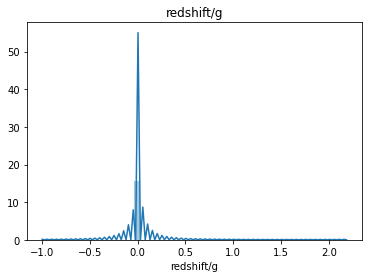

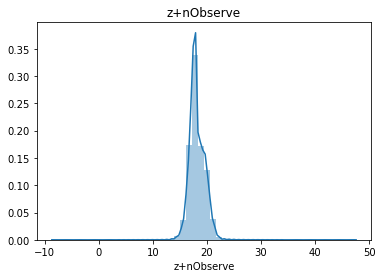

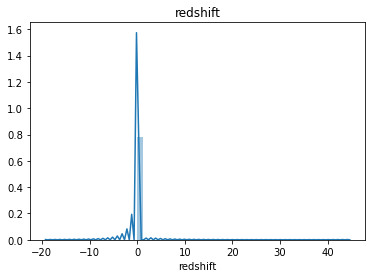

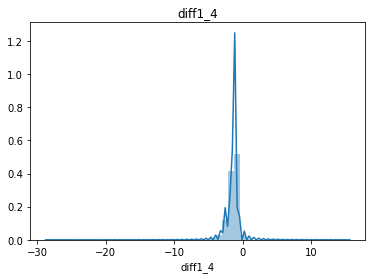

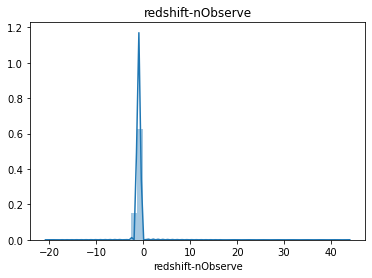

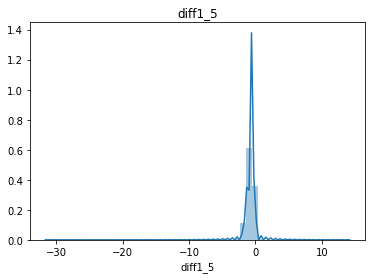

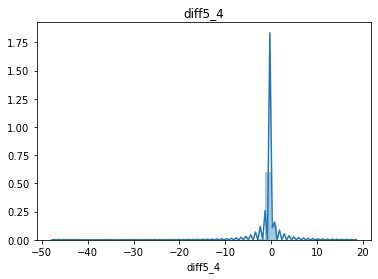

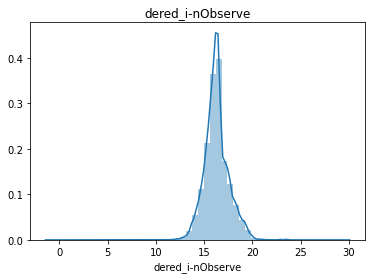

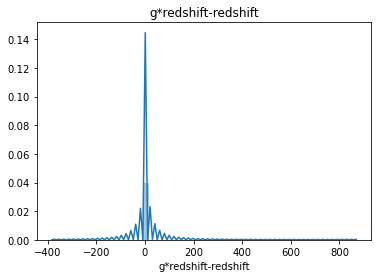

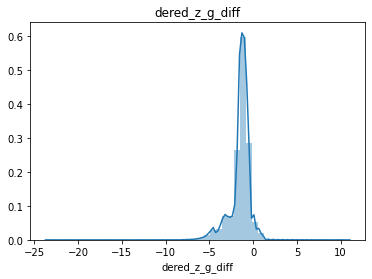

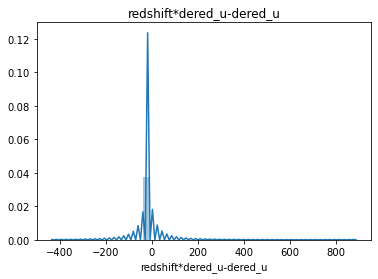

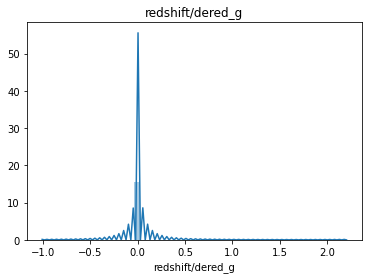

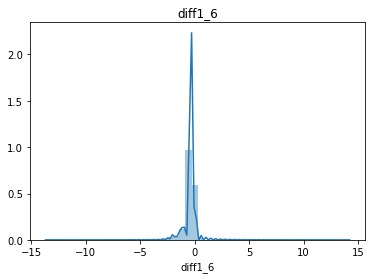

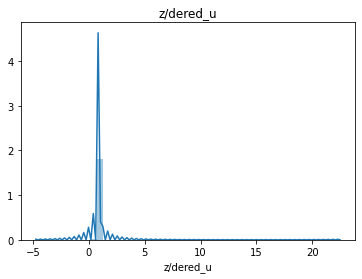

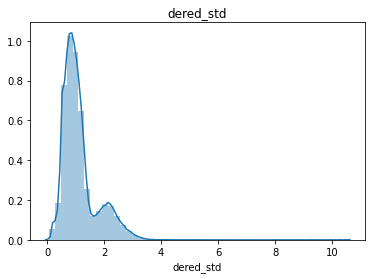

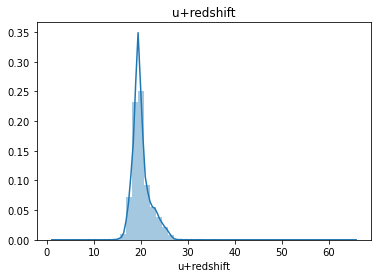

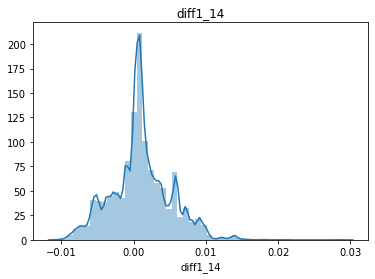

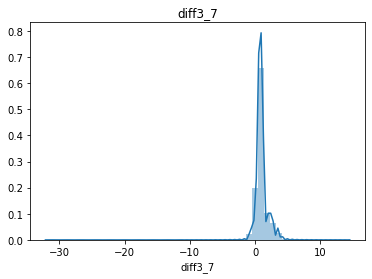

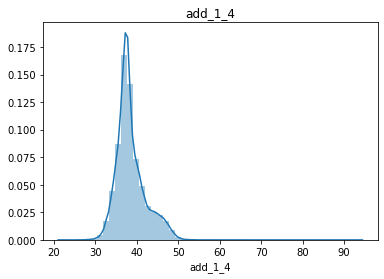

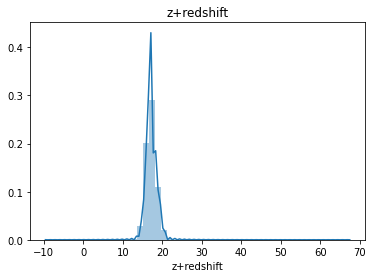

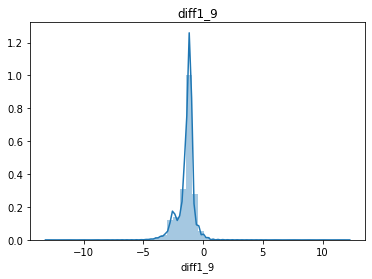

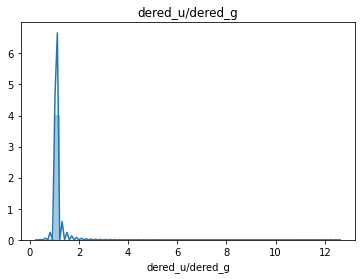

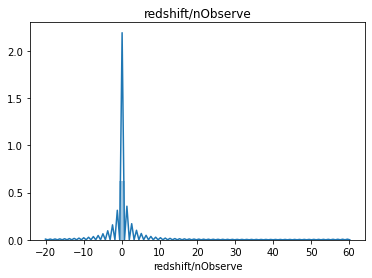

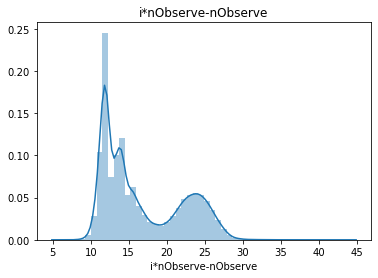

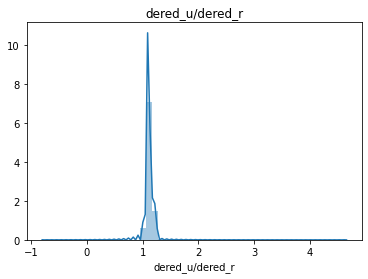

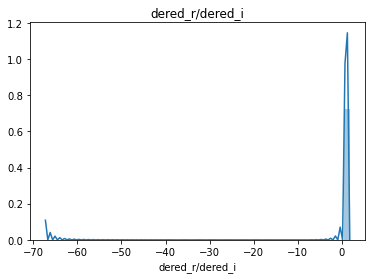

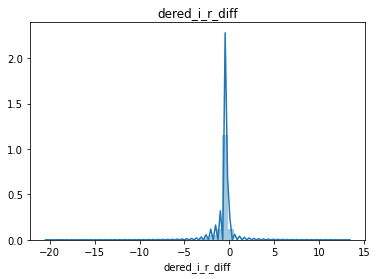

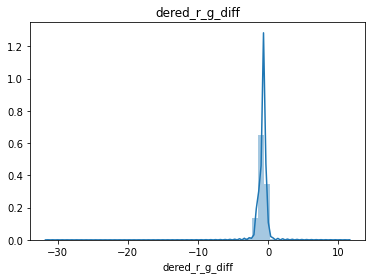

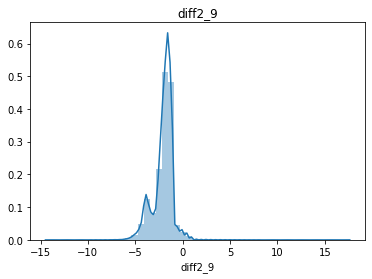

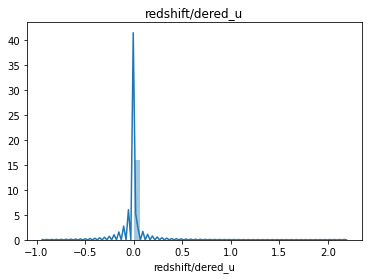

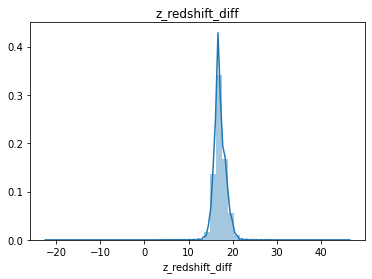

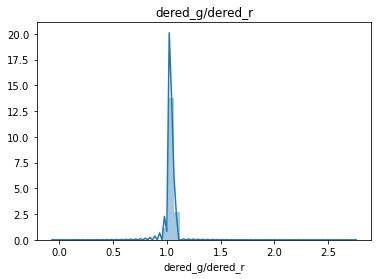

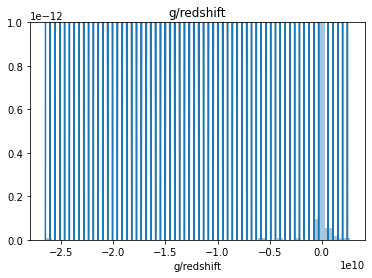

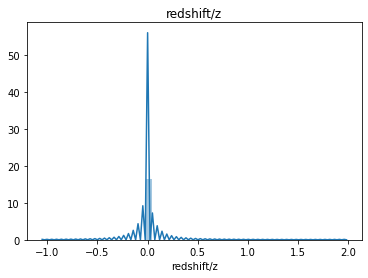

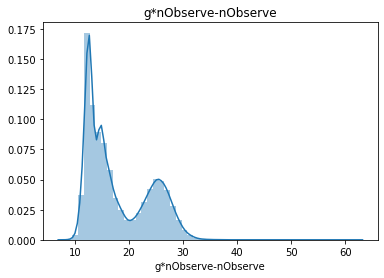

C:\Users\munan\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


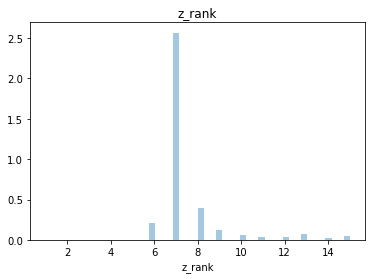

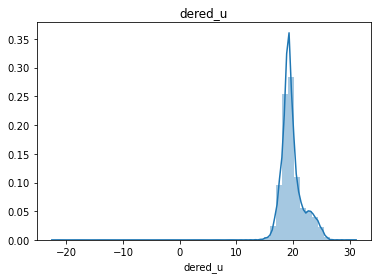

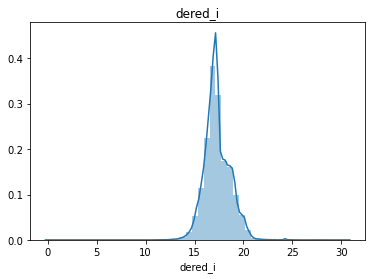

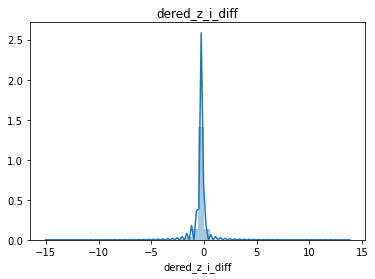

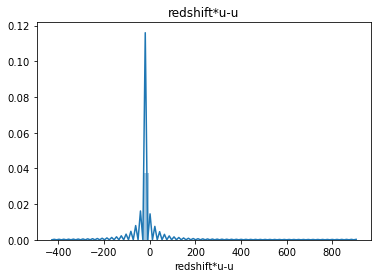

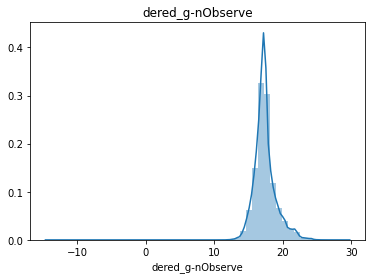

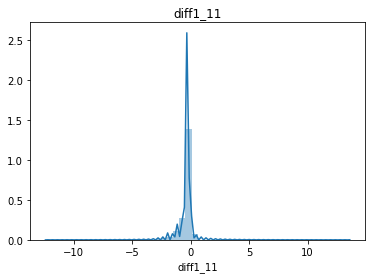

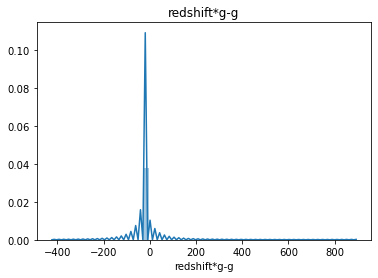

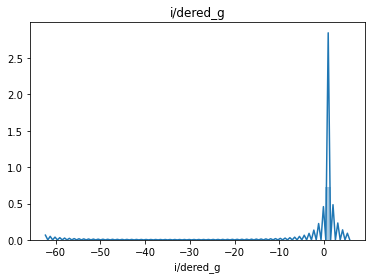

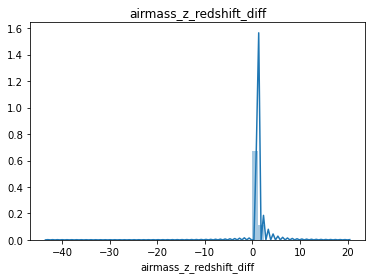

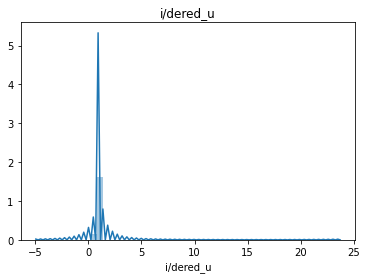

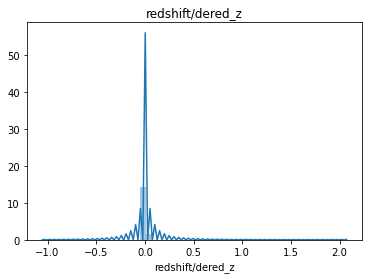

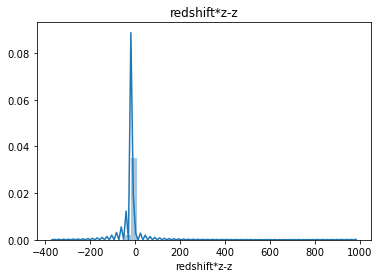

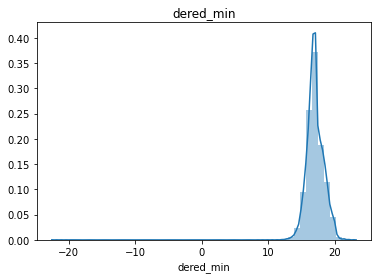

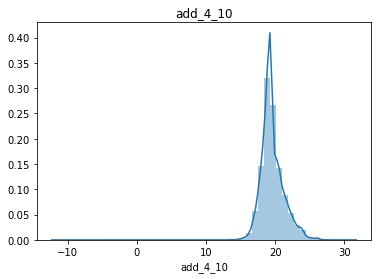

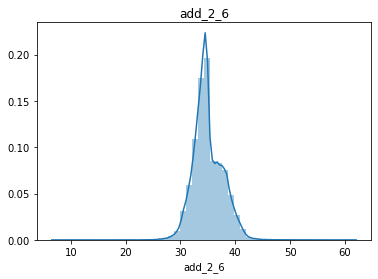

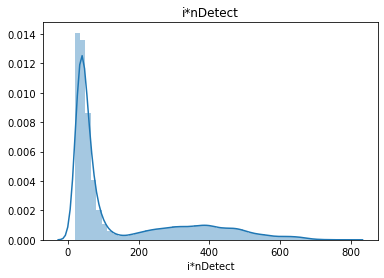

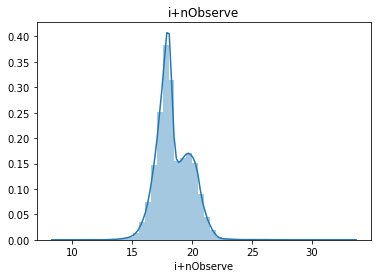

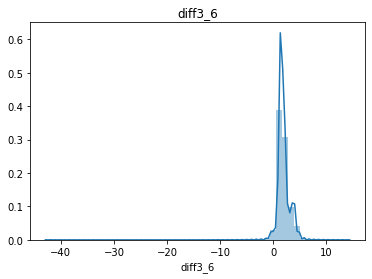

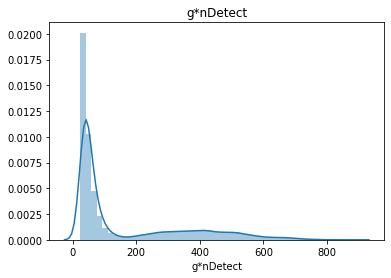

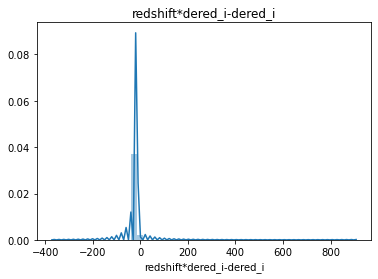

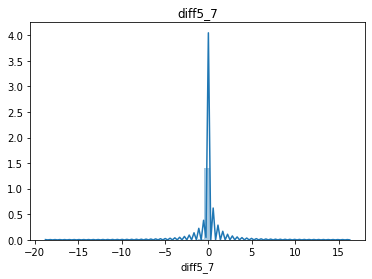

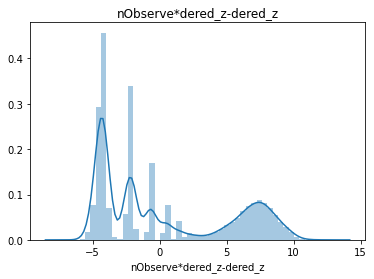

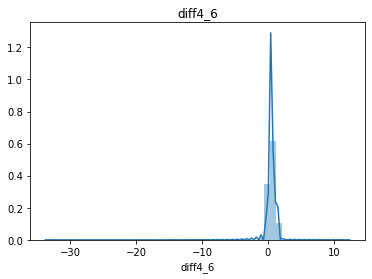

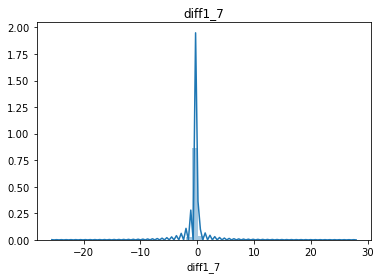

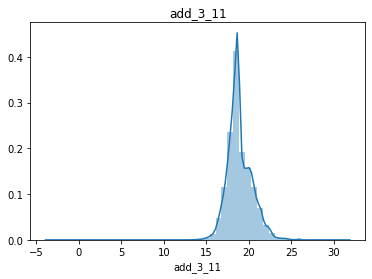

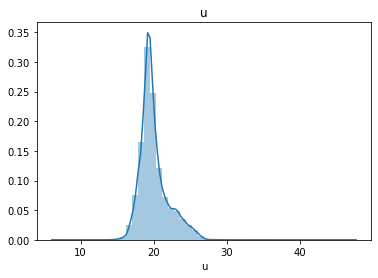

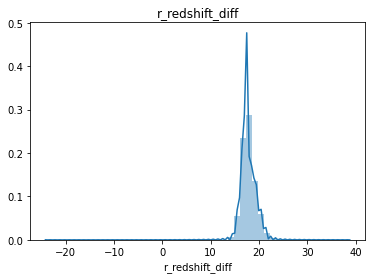

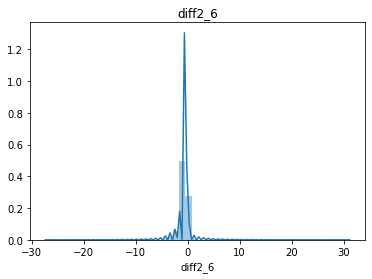

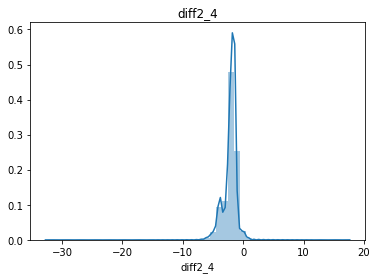

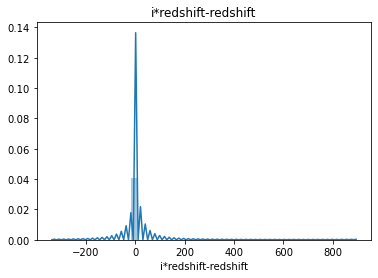

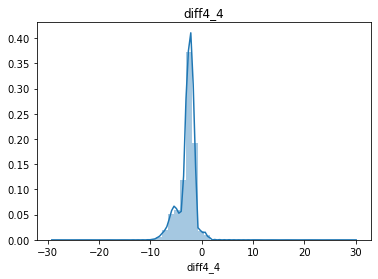

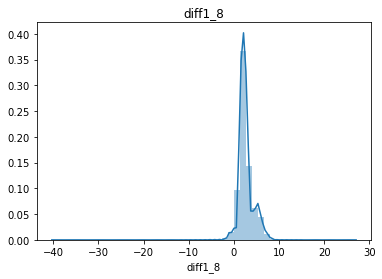

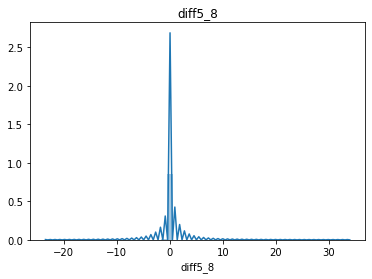

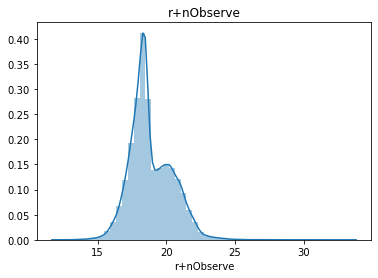

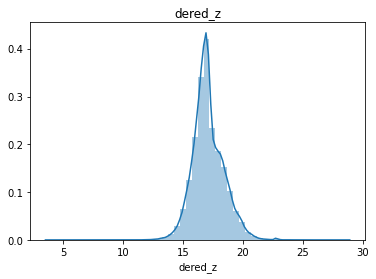

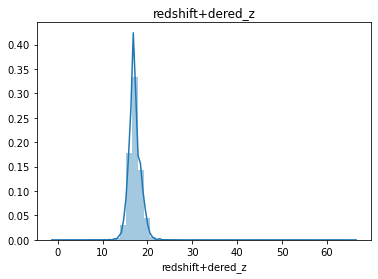

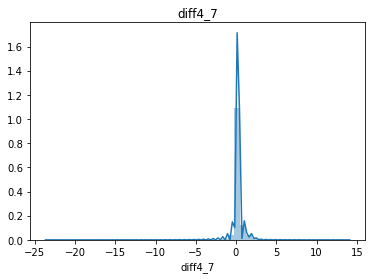

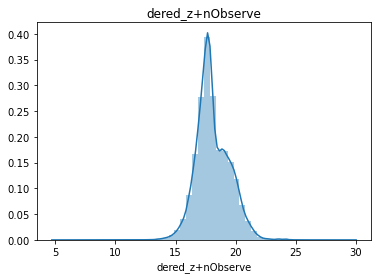

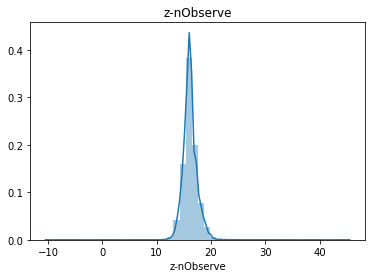

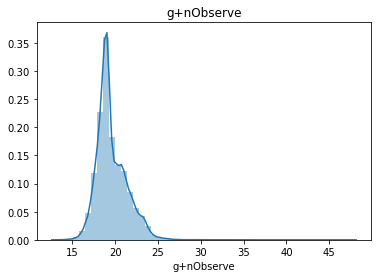

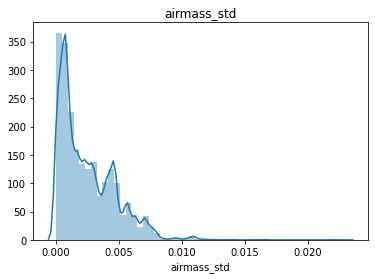

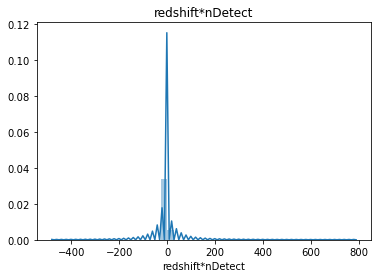

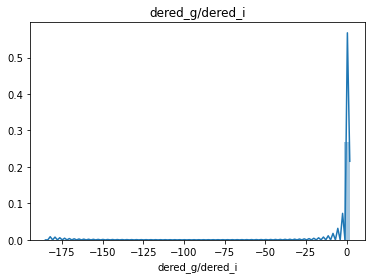

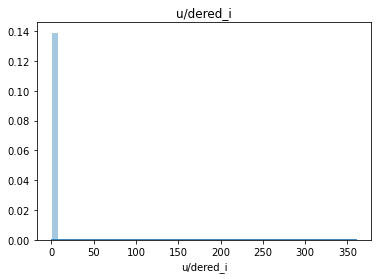

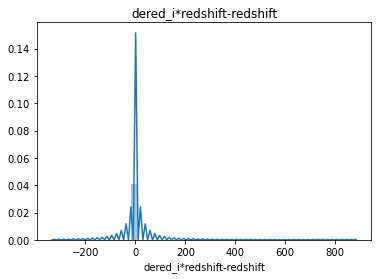

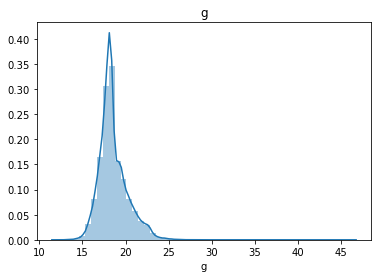

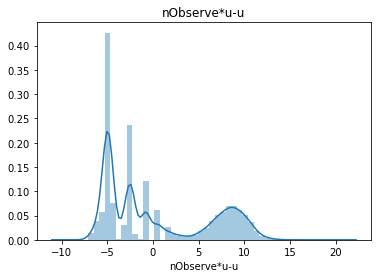

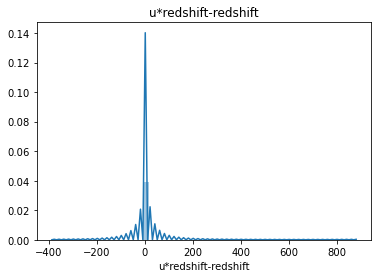

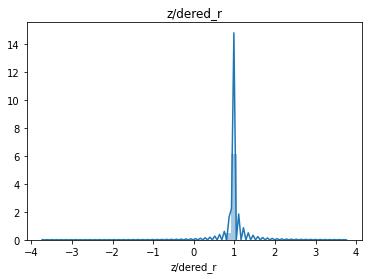

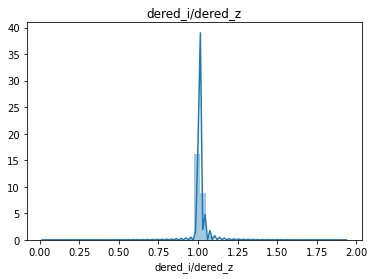

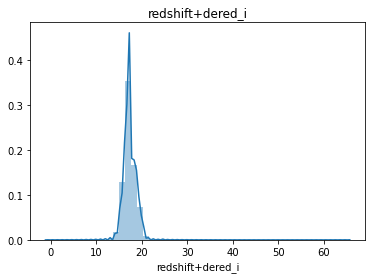

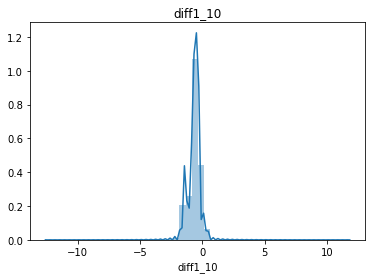

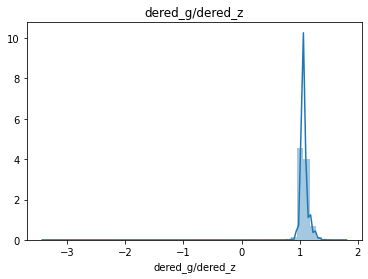

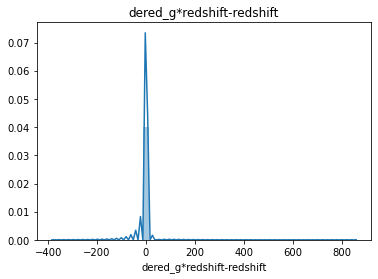

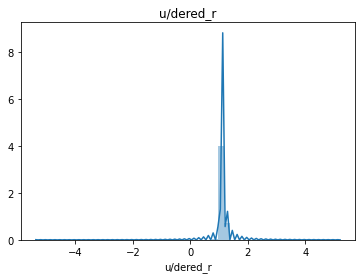

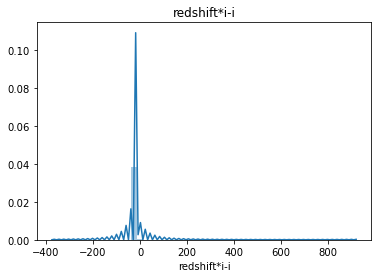

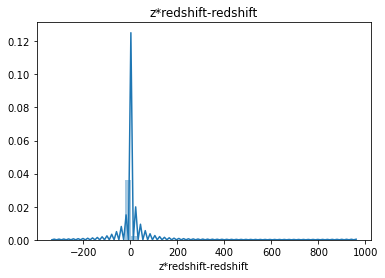

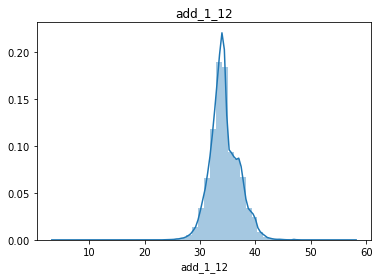

C:\Users\munan\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


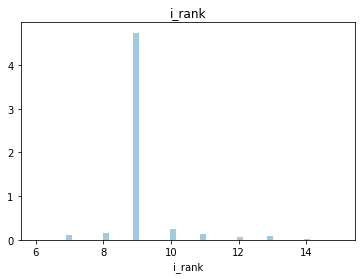

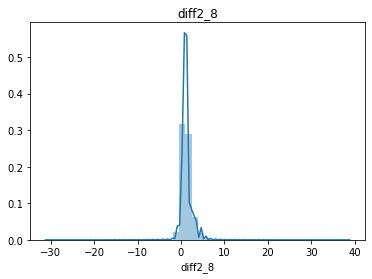

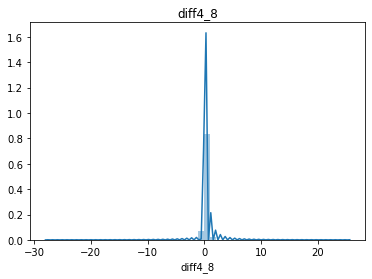

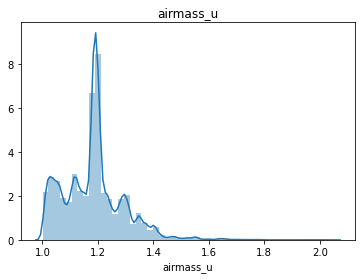

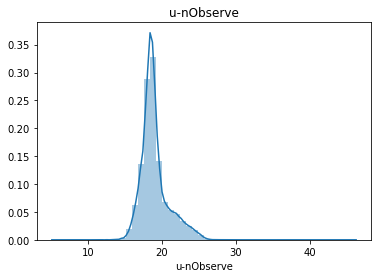

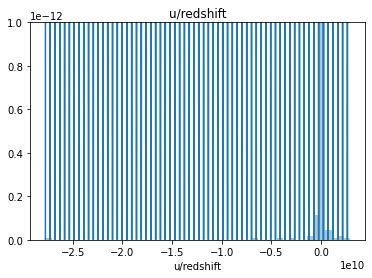

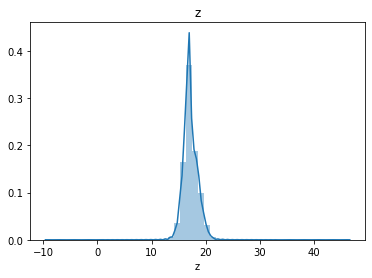

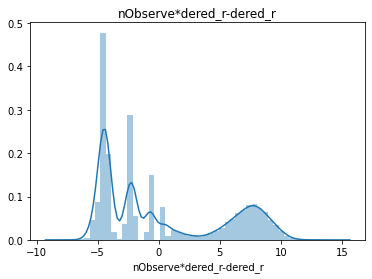

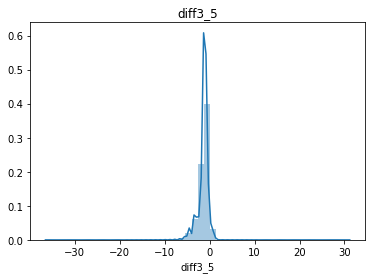

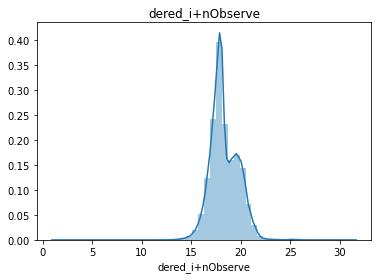

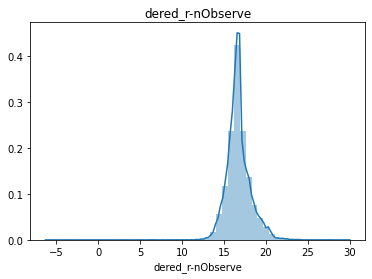

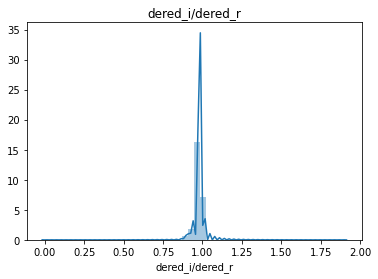

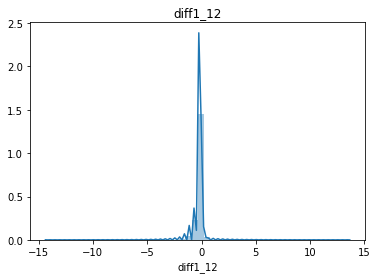

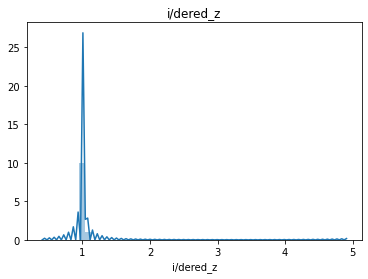

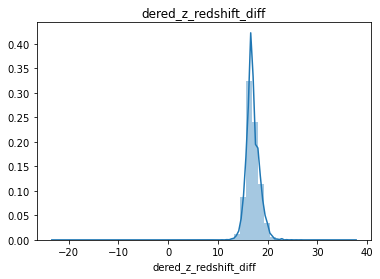

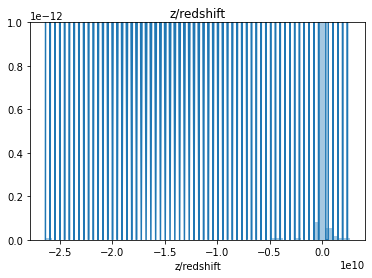

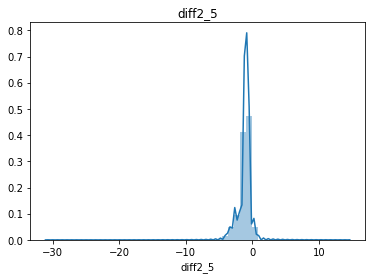

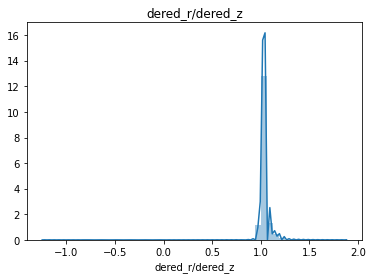

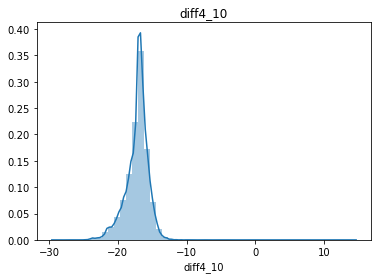

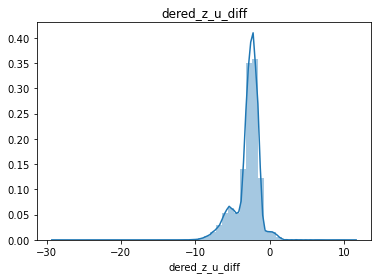

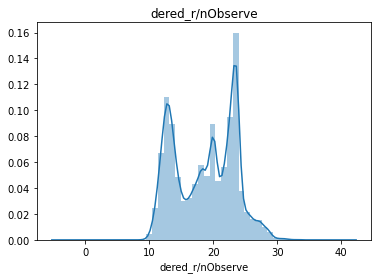

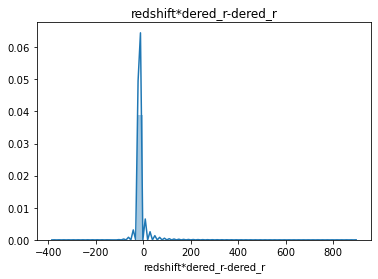

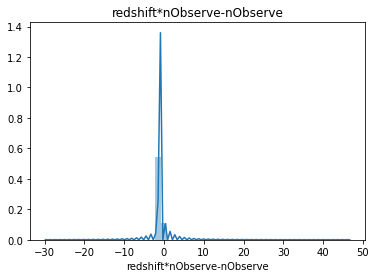

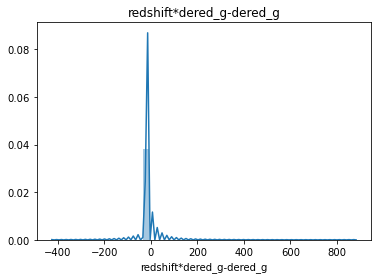

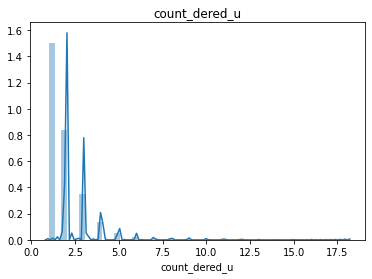

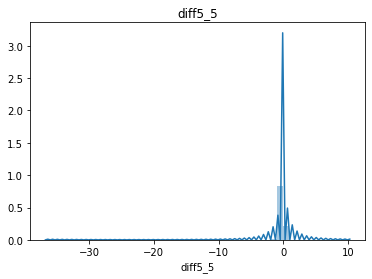

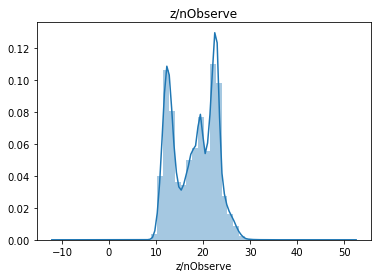

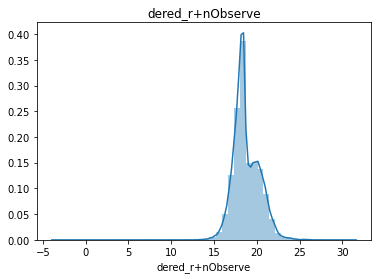

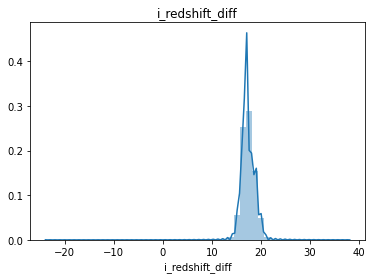

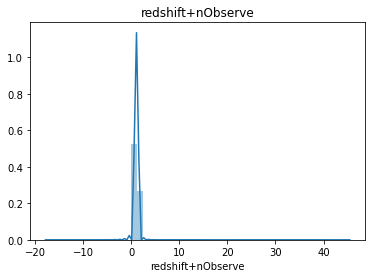

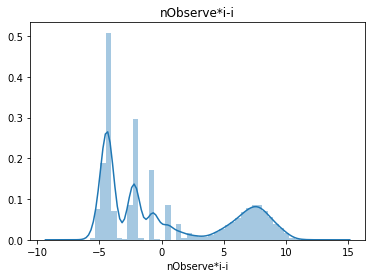

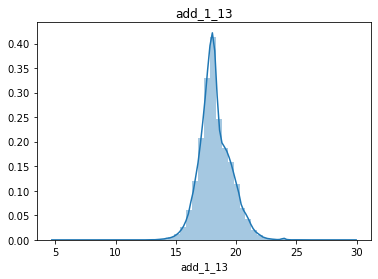

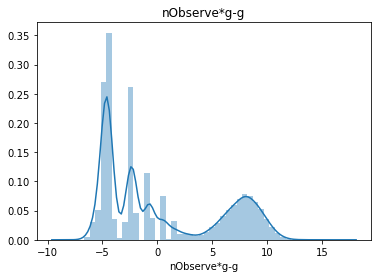

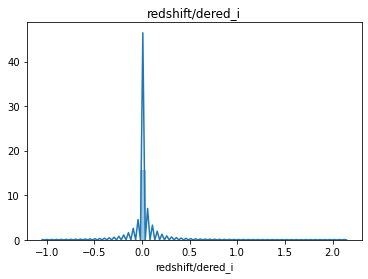

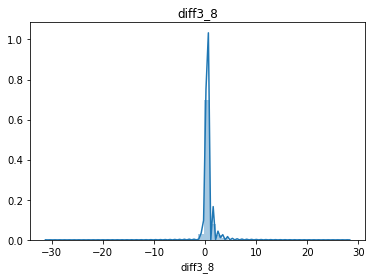

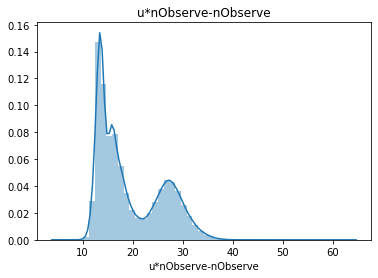

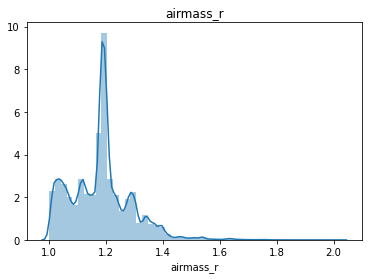

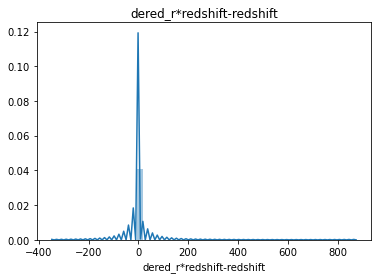

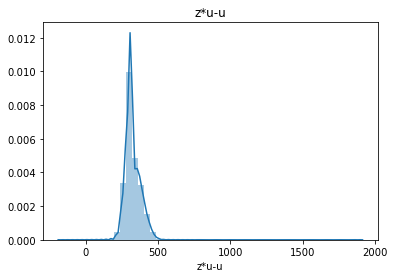

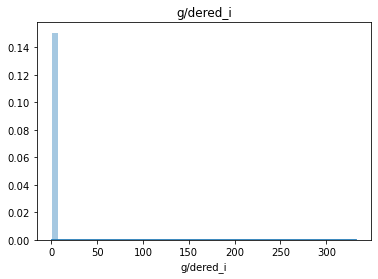

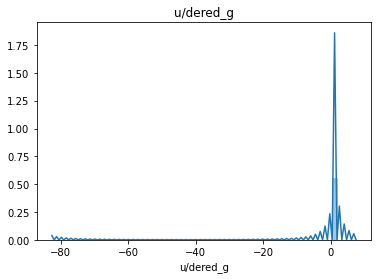

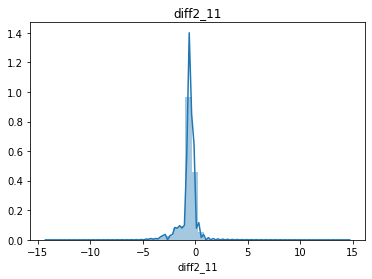

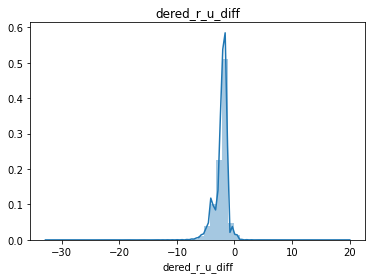

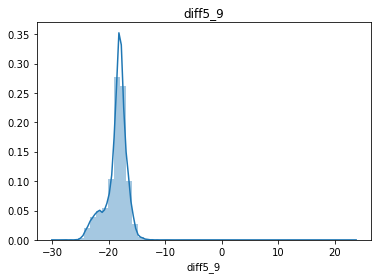

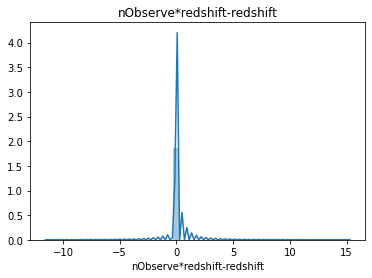

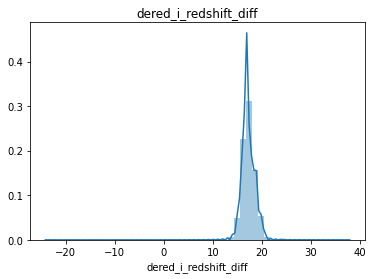

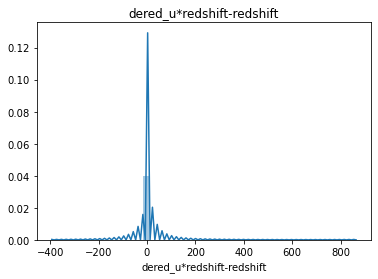

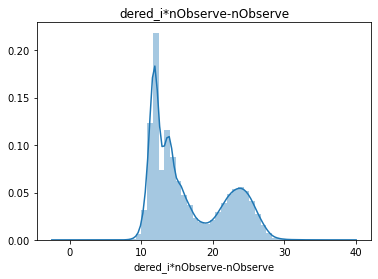

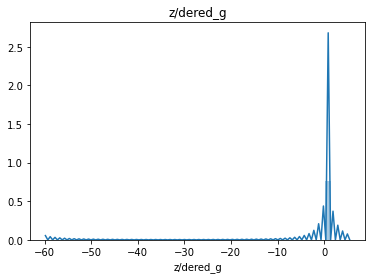

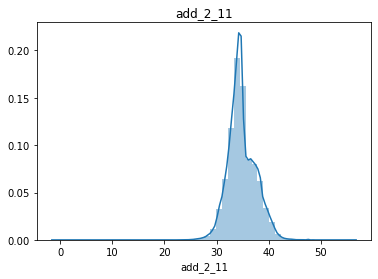

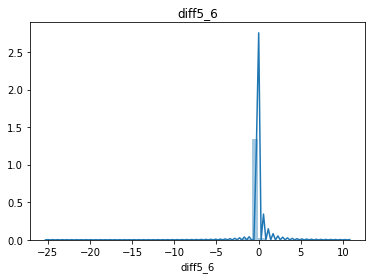

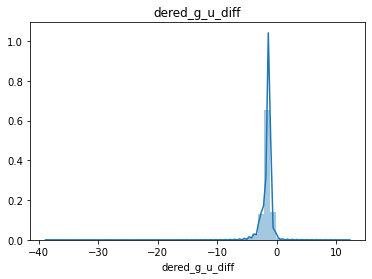

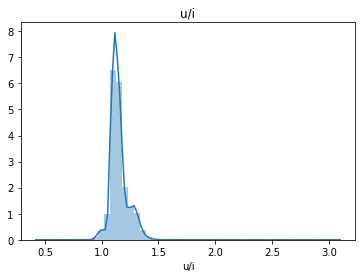

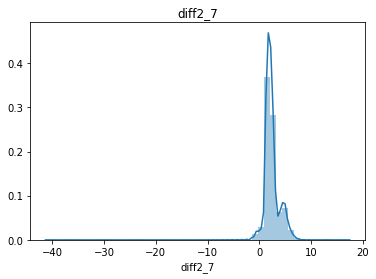

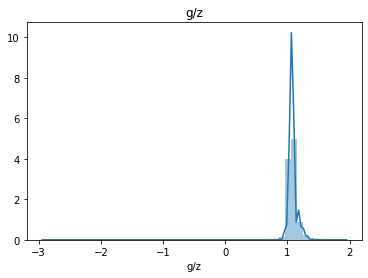

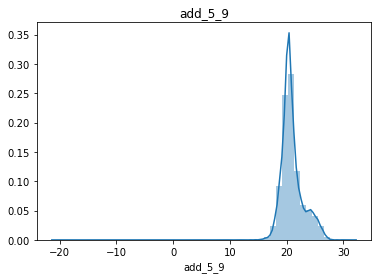

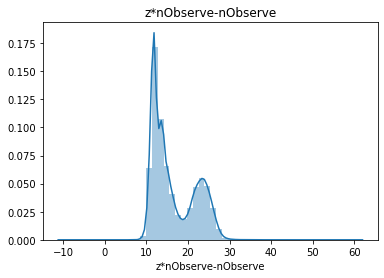

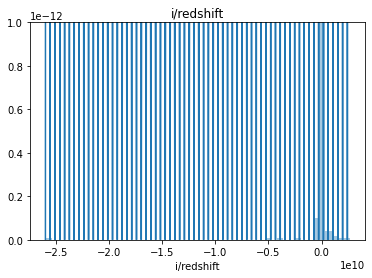

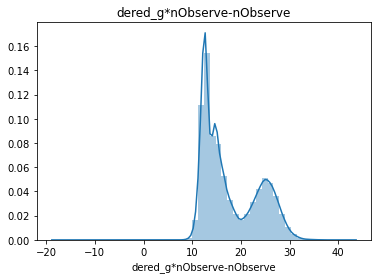

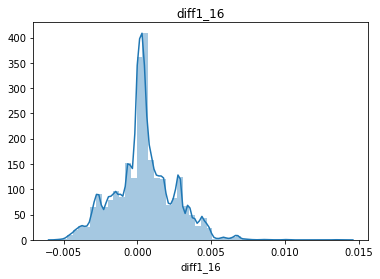

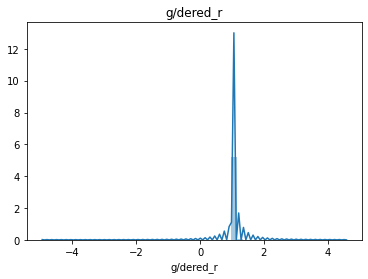

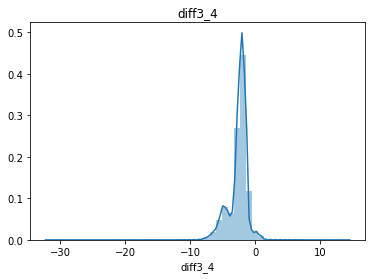

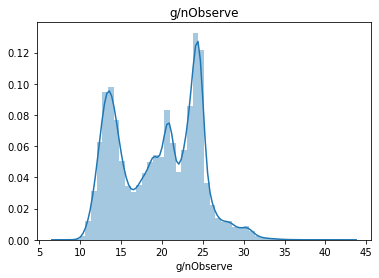

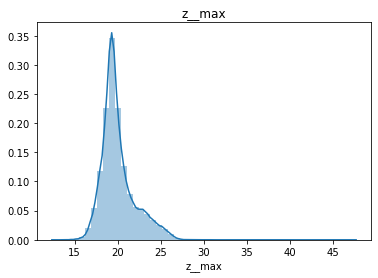

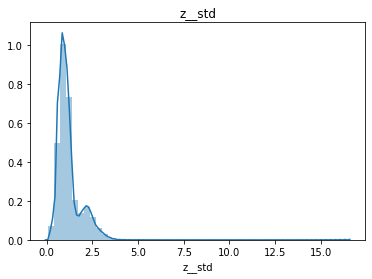

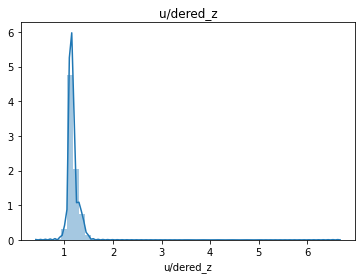

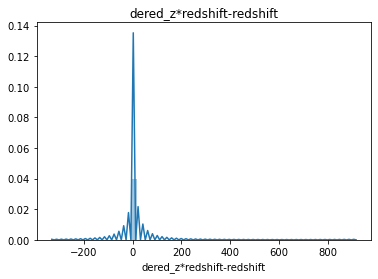

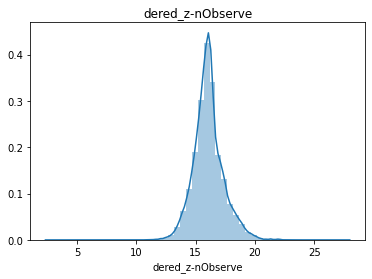

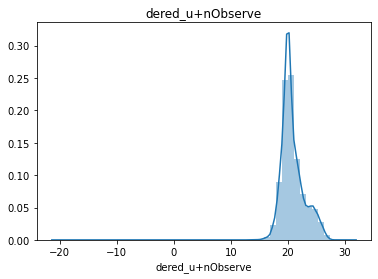

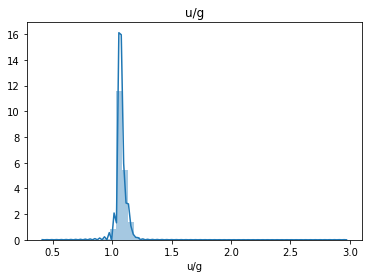

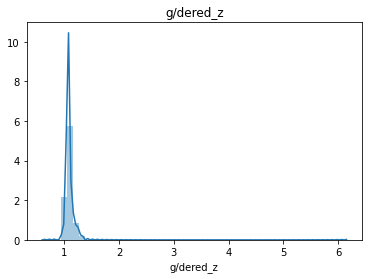

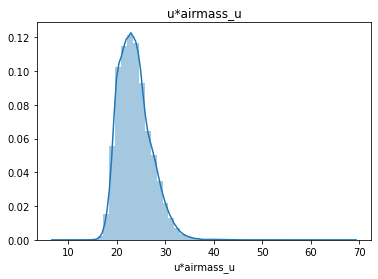

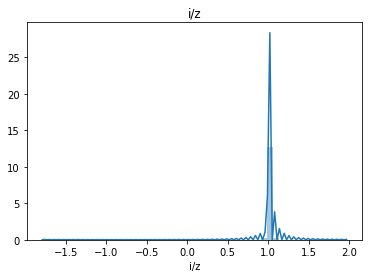

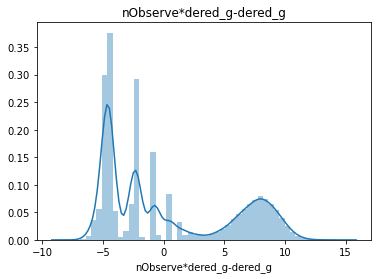

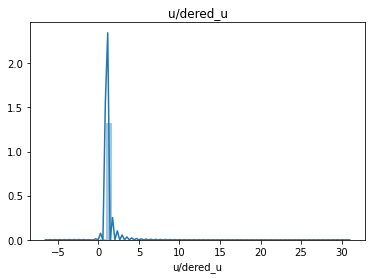

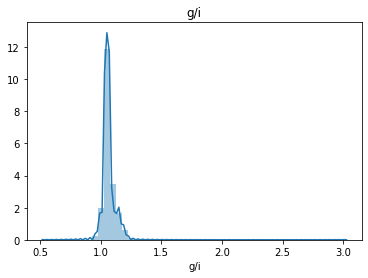

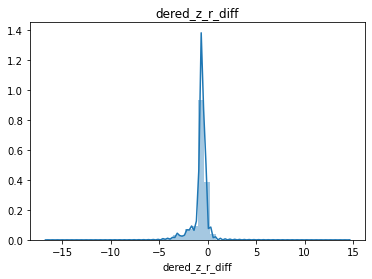

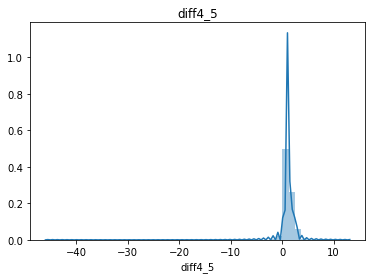

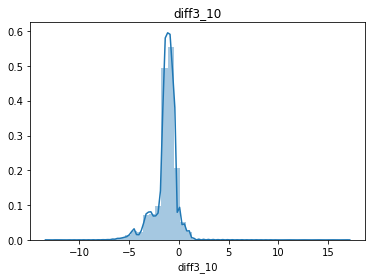

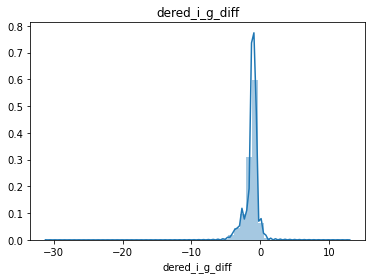

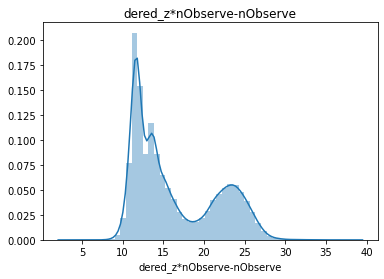

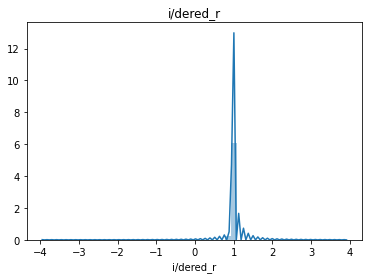

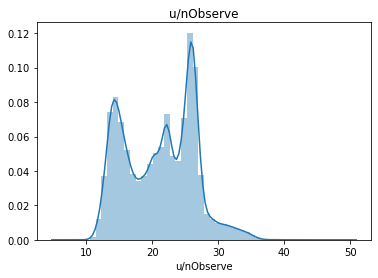

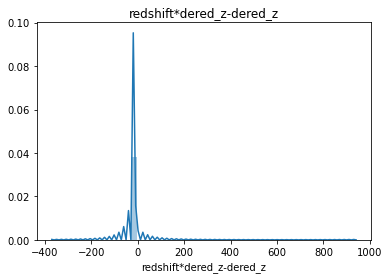

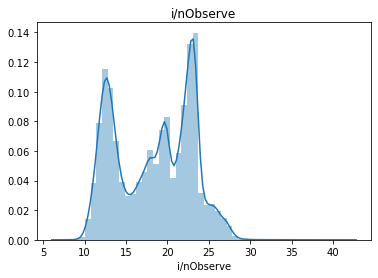

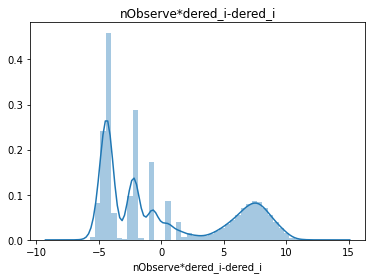

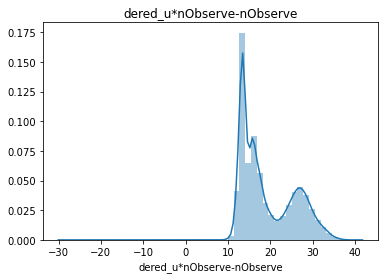

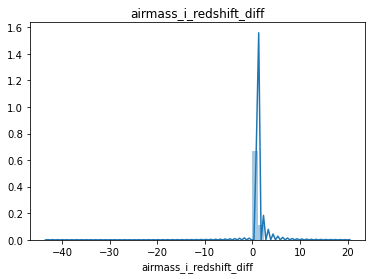

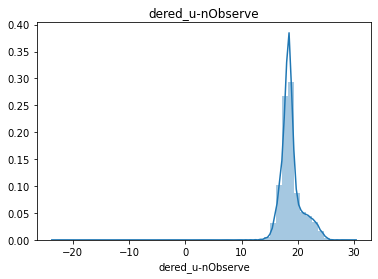

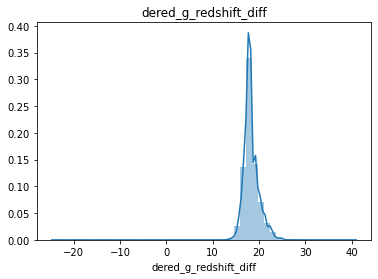

C:\Users\munan\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


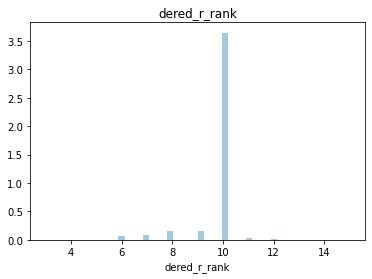

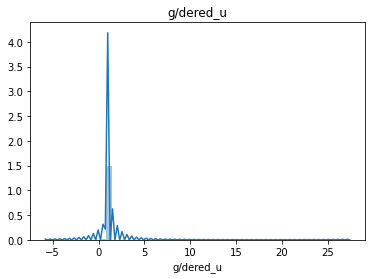

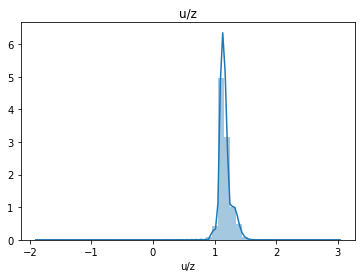

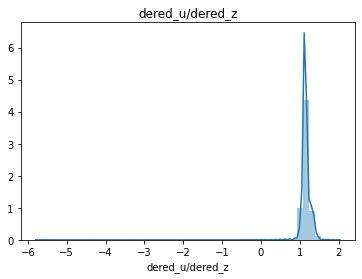

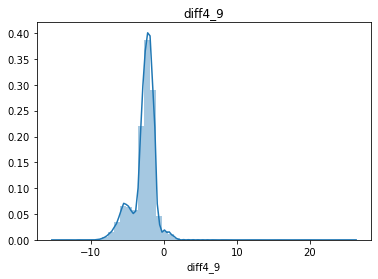

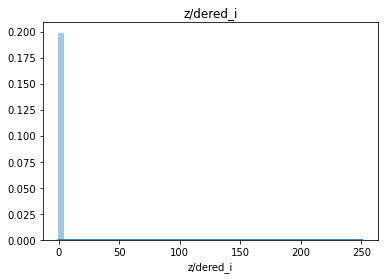

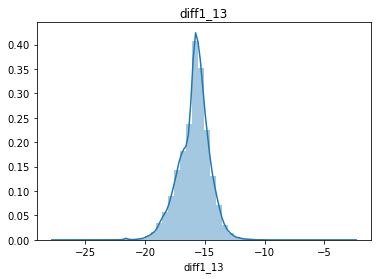

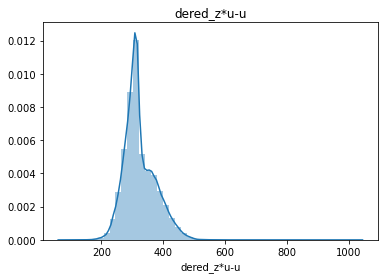

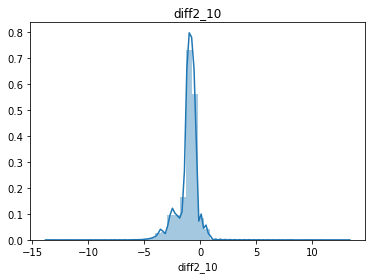

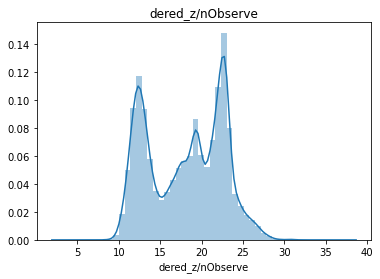

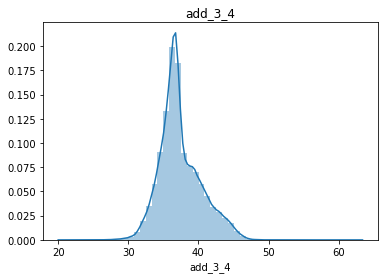

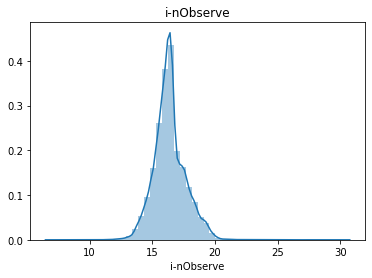

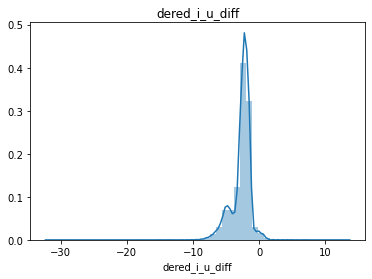

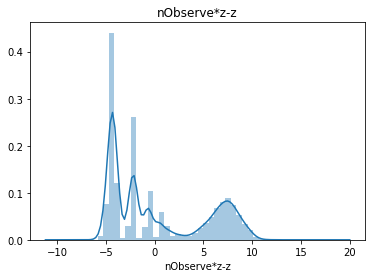

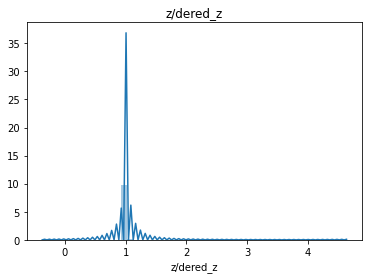

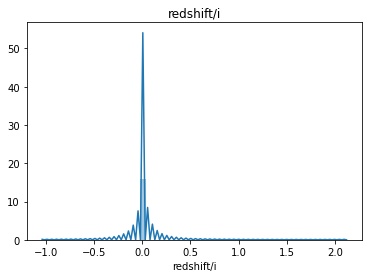

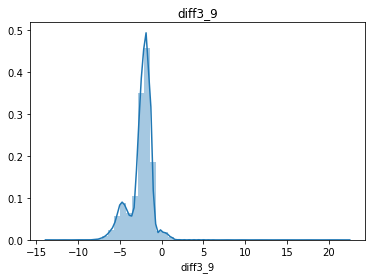

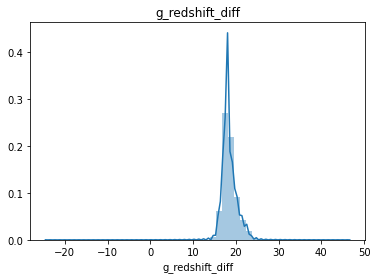

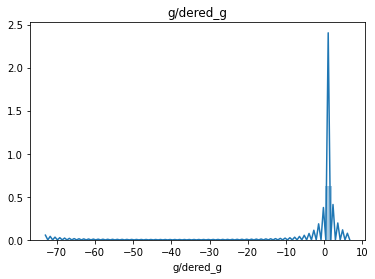

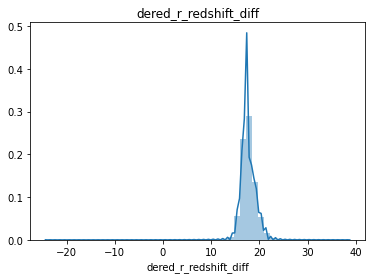

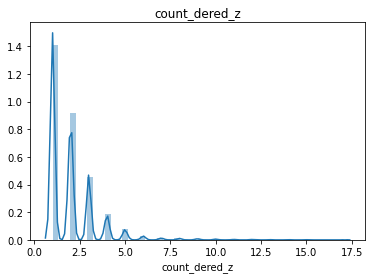

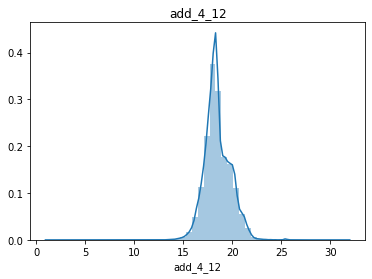

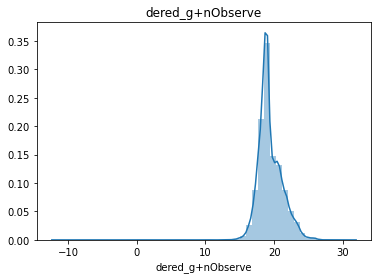

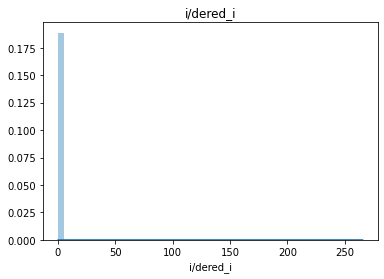

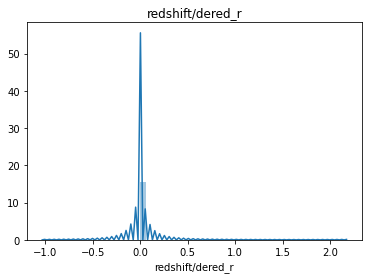

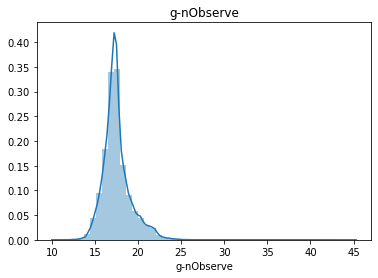

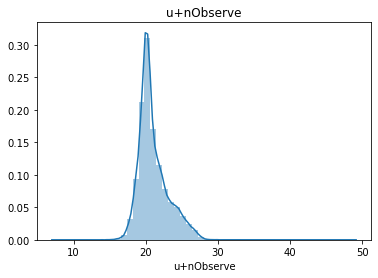

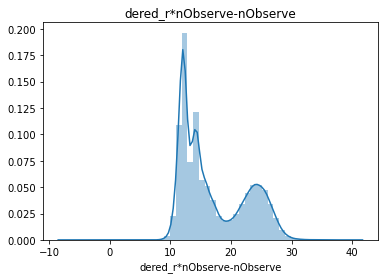

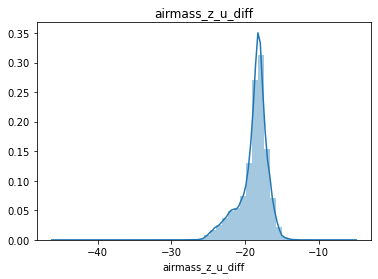

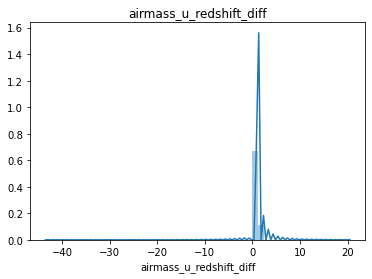

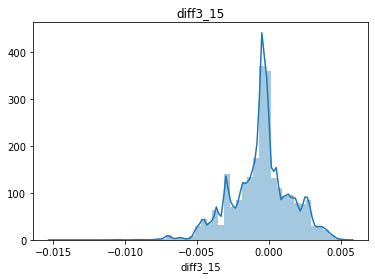

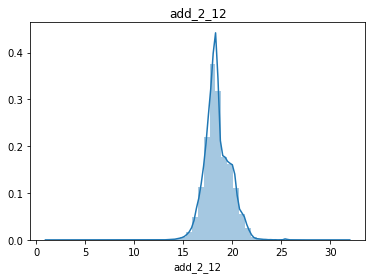

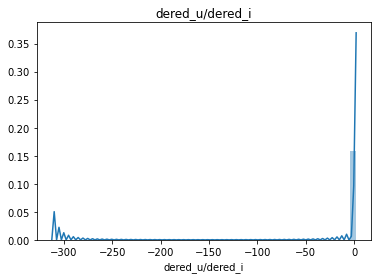

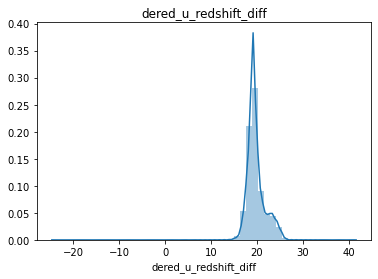

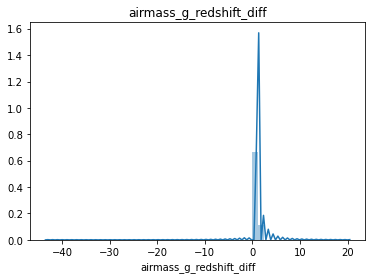

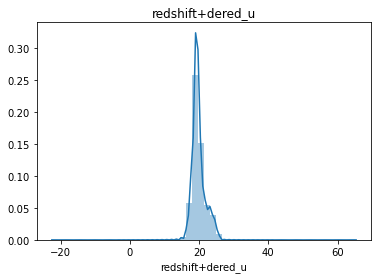

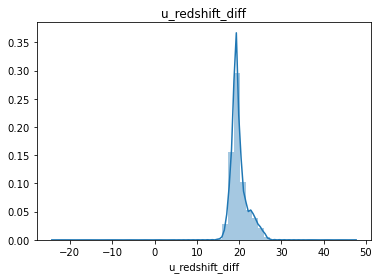

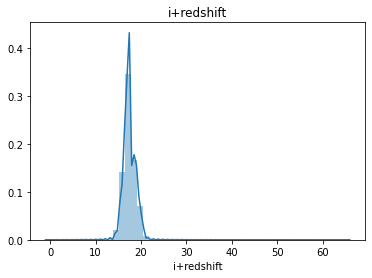

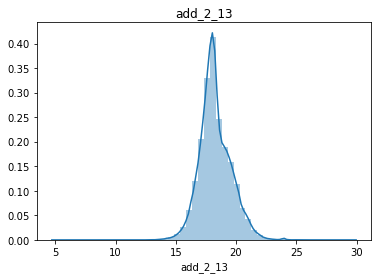

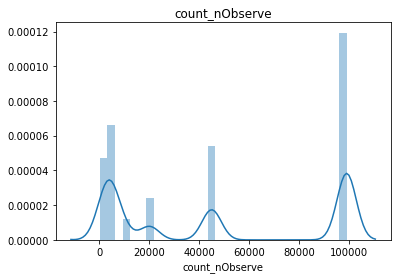

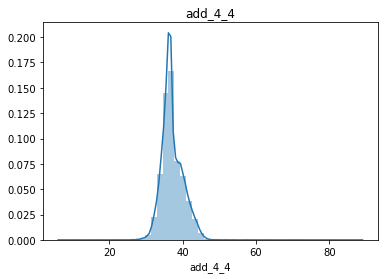

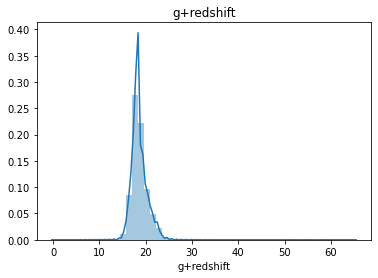

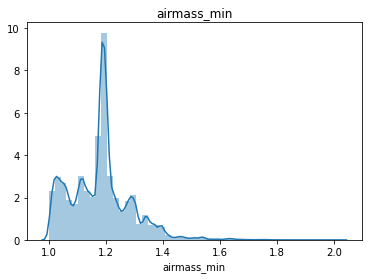

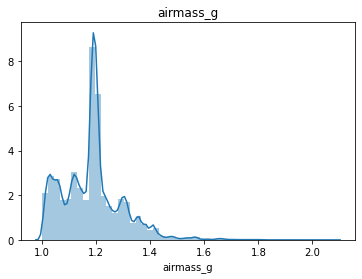

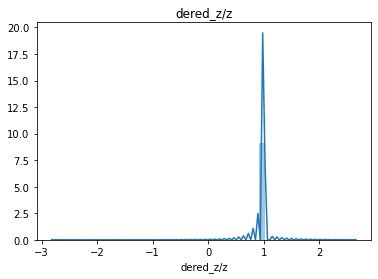

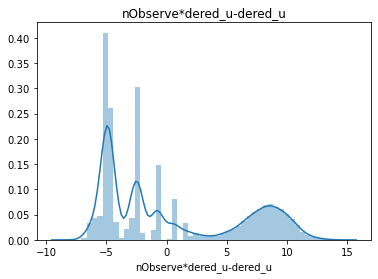

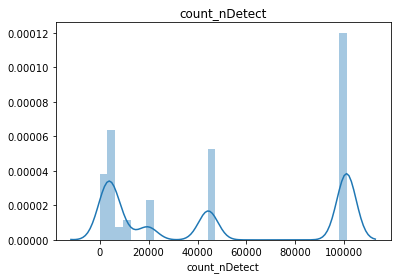

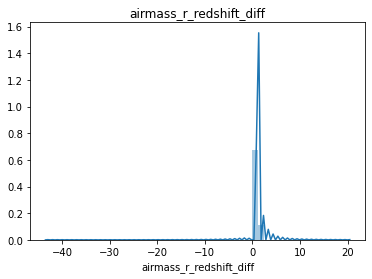

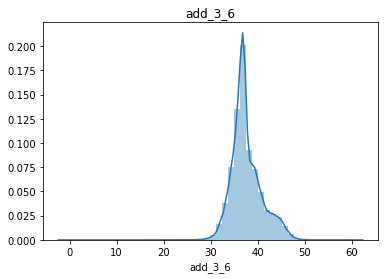

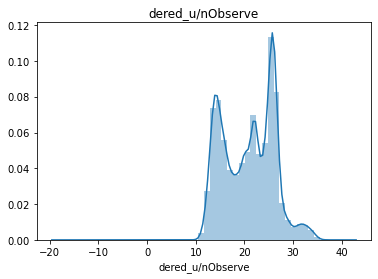

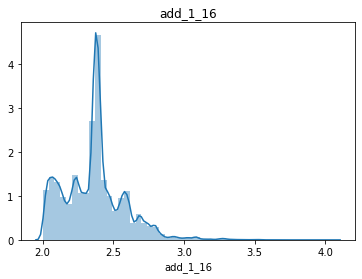

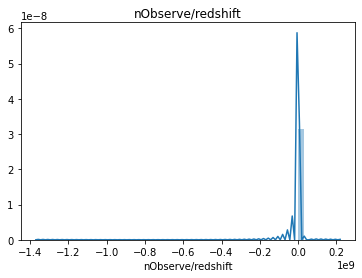

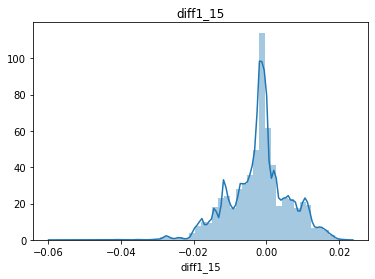

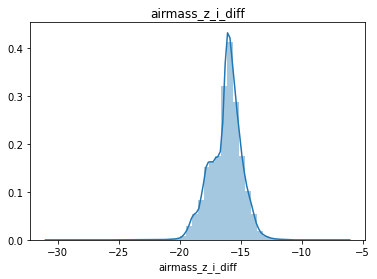

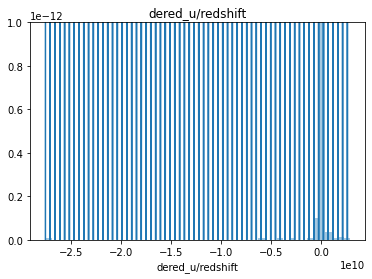

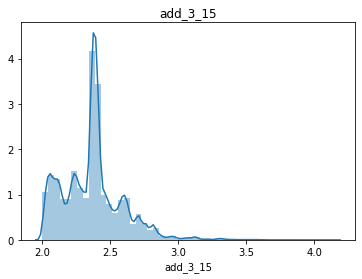

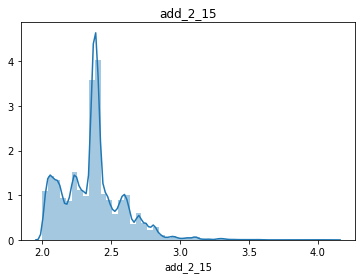

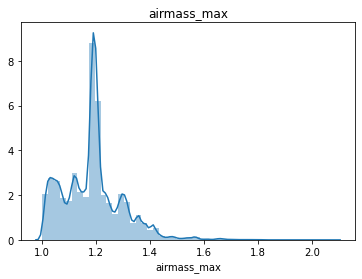

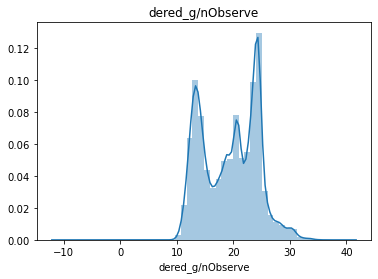

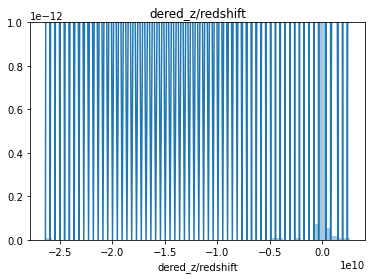

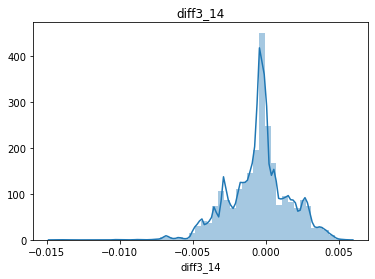

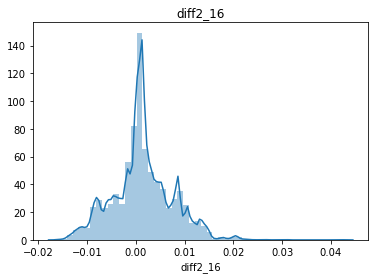

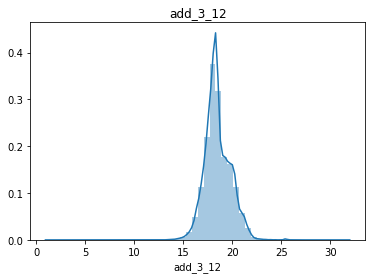

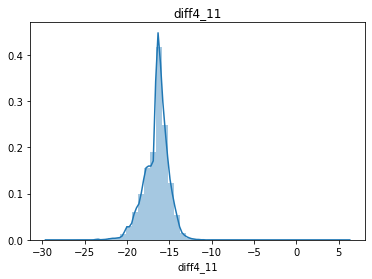

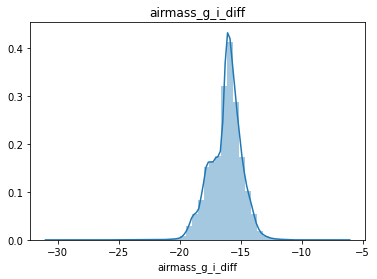

In [374]:
for col in numerical_feature:
    sns.distplot(train.loc[train[col].notnull(), col])
    plt.title(col)
    plt.show()




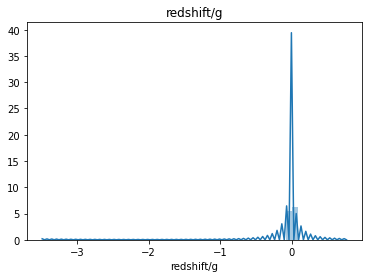

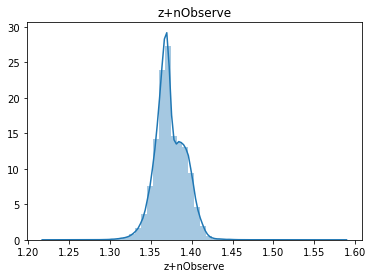

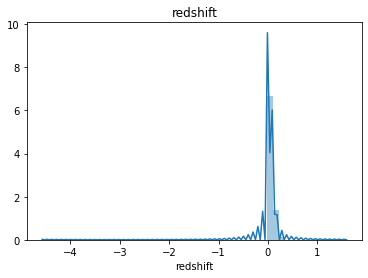

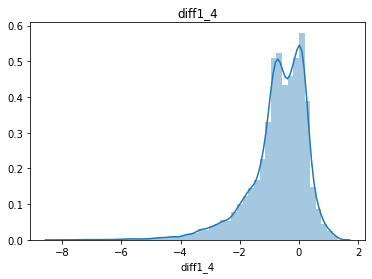

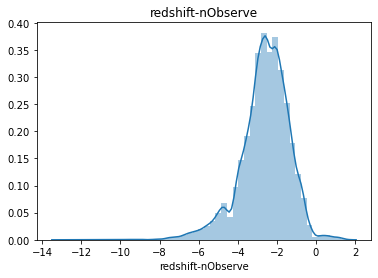

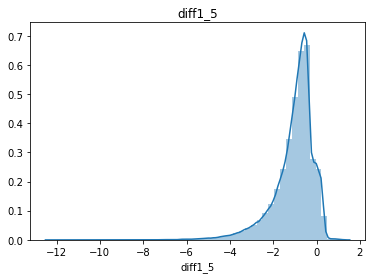

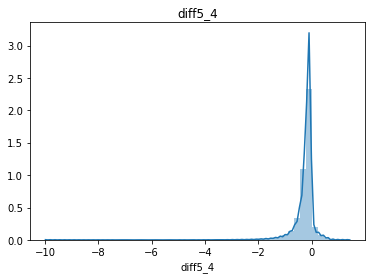

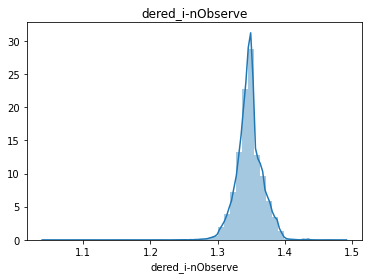

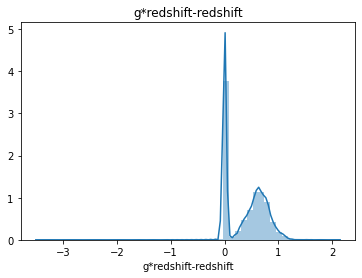

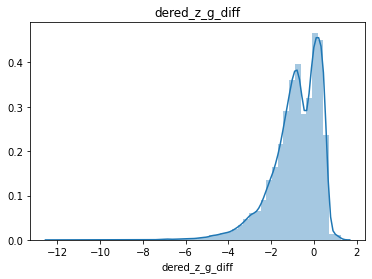

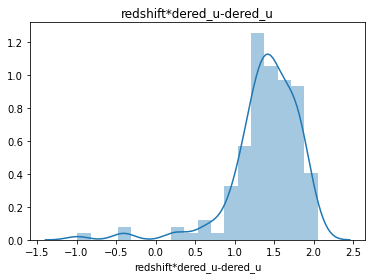

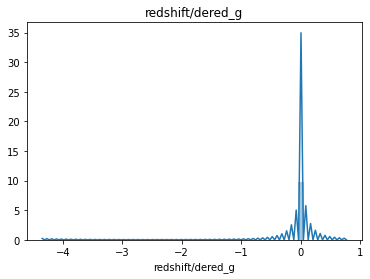

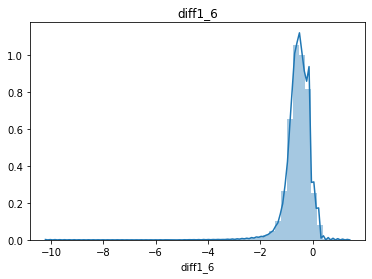

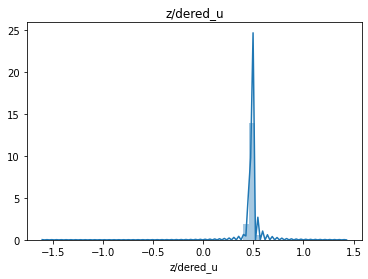

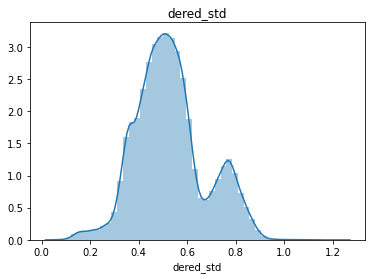

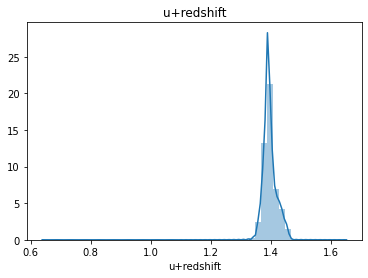

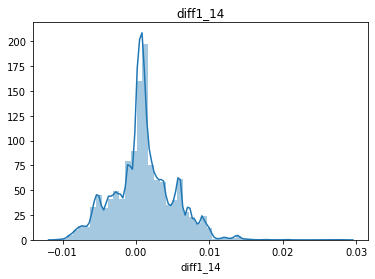

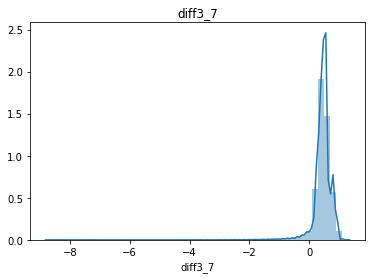

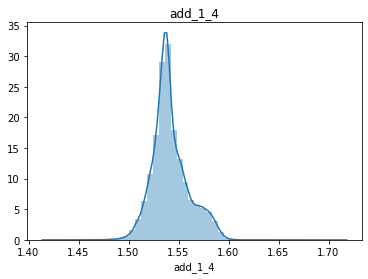

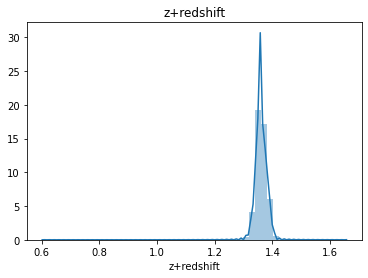

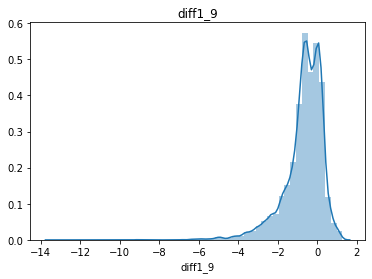

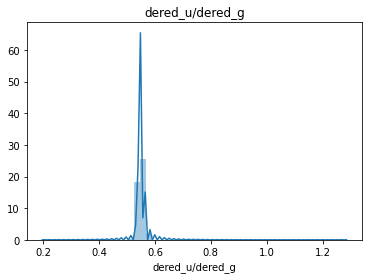

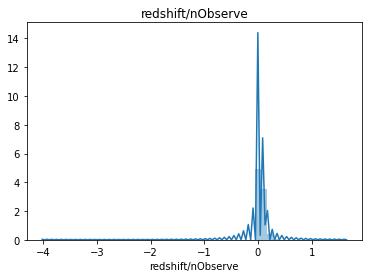

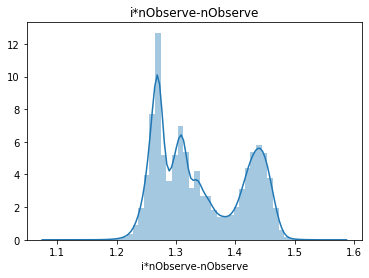

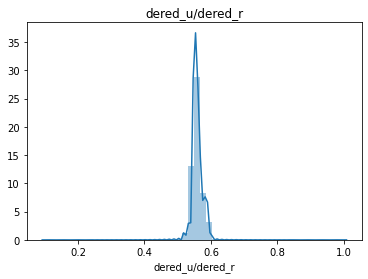

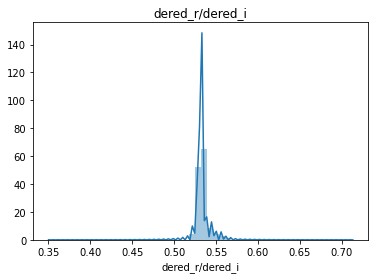

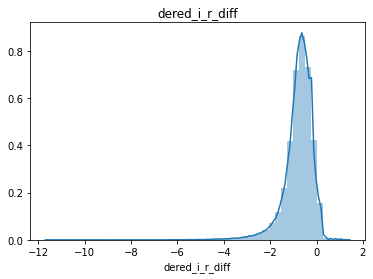

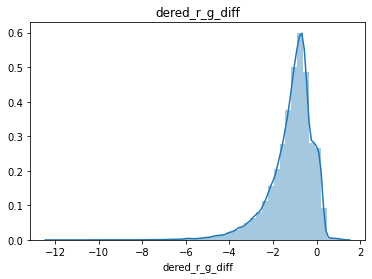

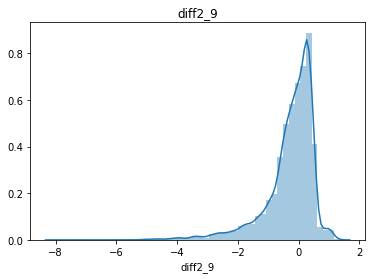

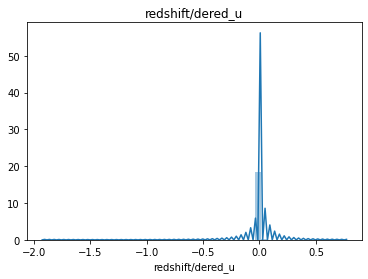

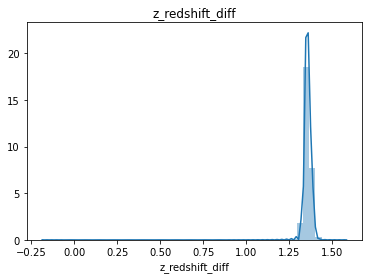

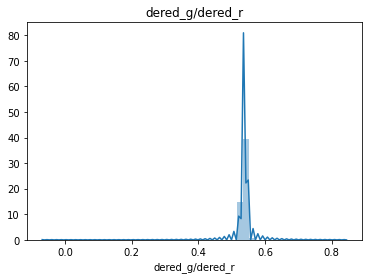

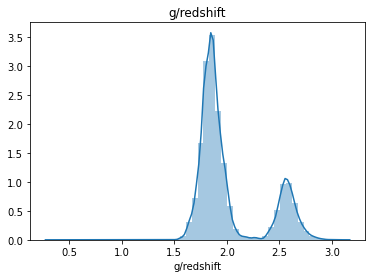

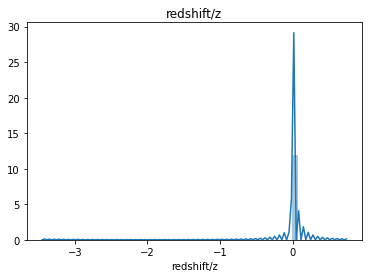

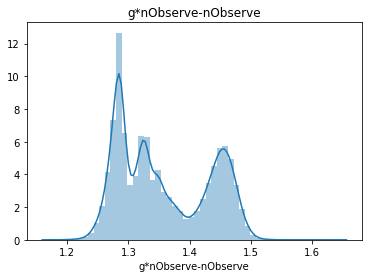

C:\Users\munan\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


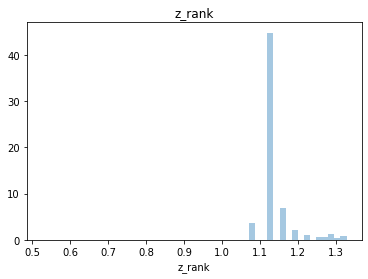

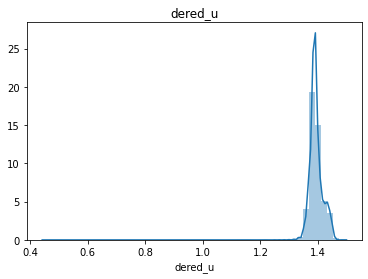

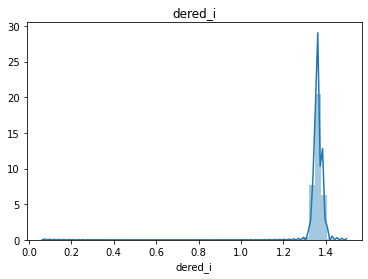

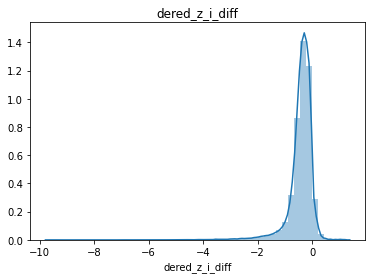

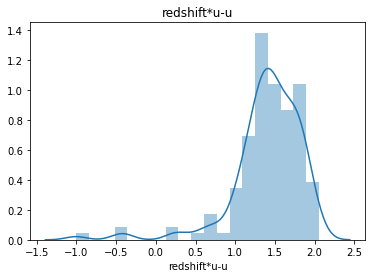

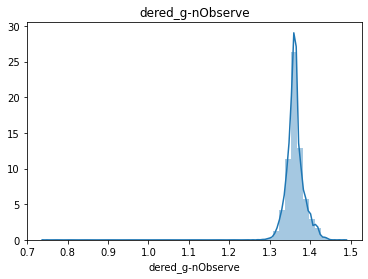

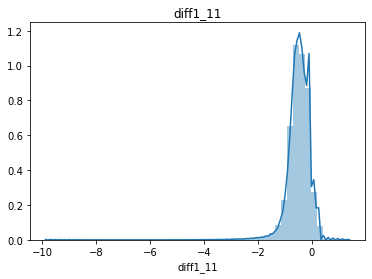

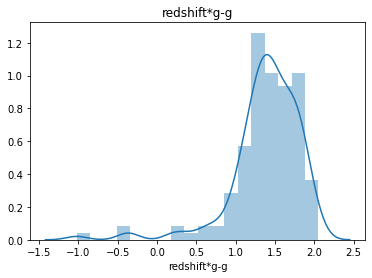

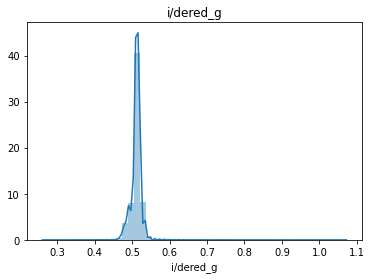

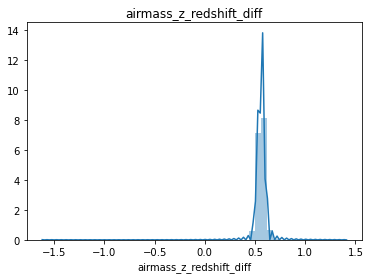

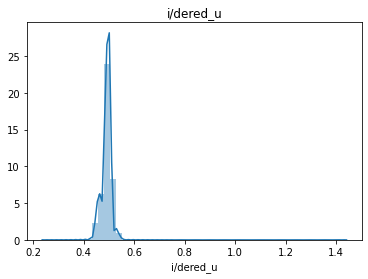

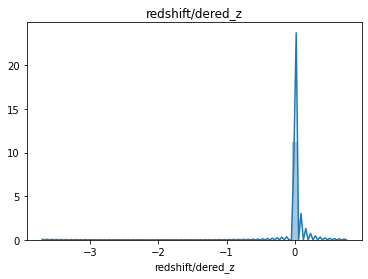

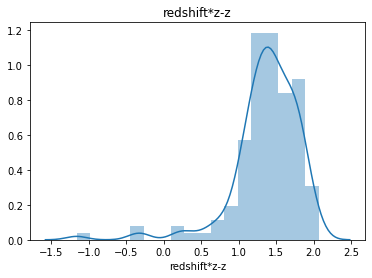

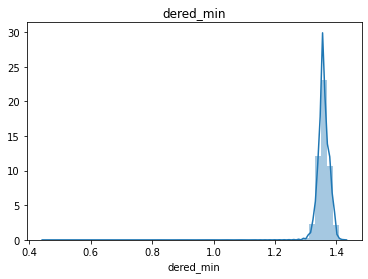

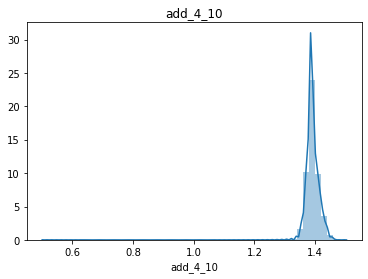

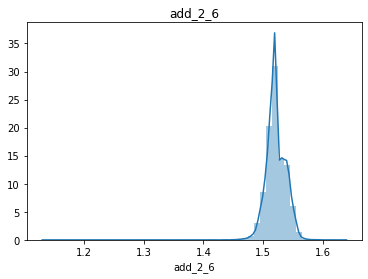

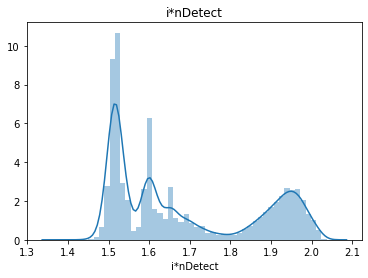

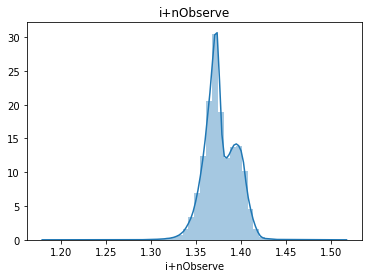

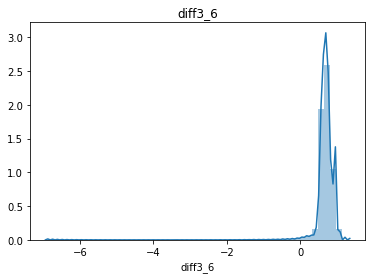

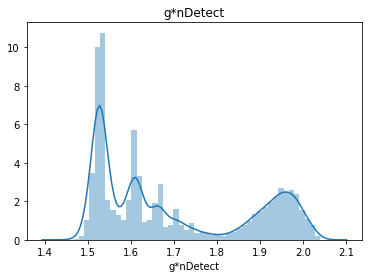

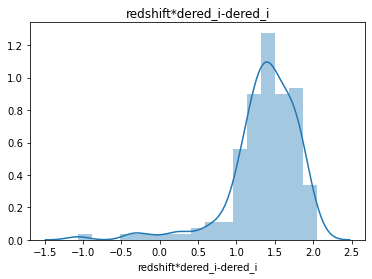

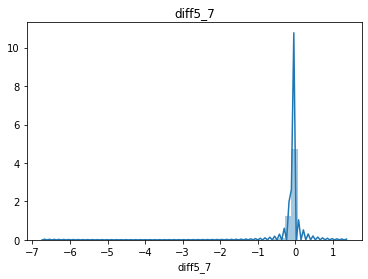

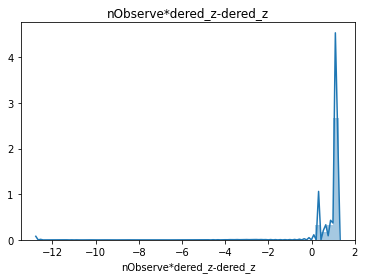

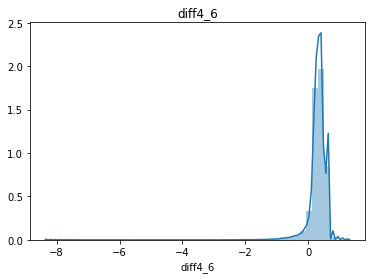

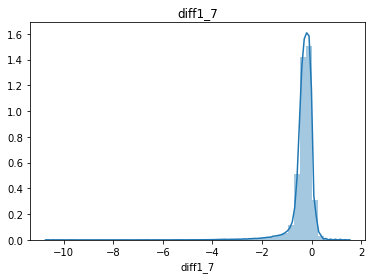

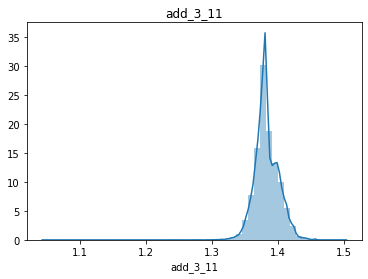

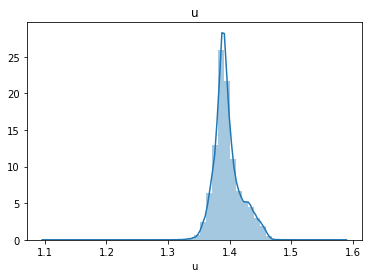

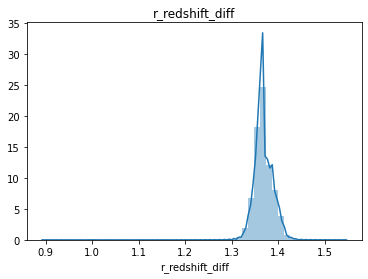

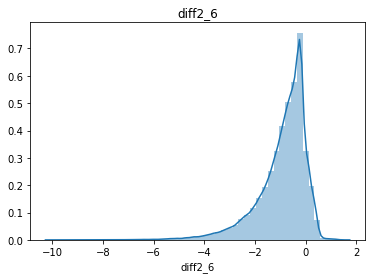

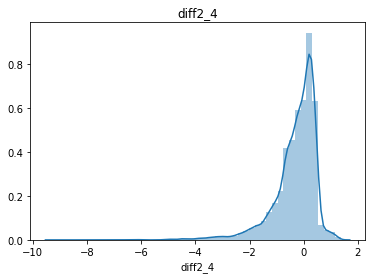

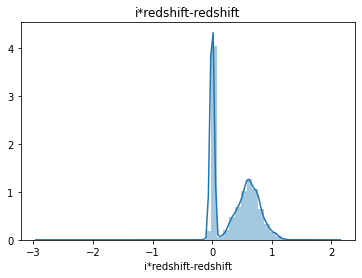

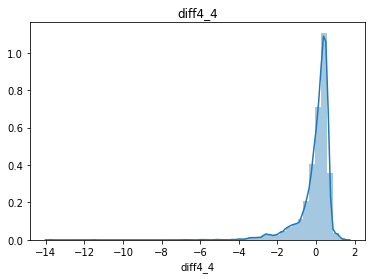

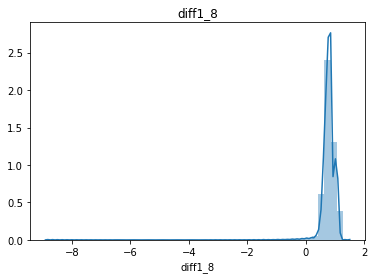

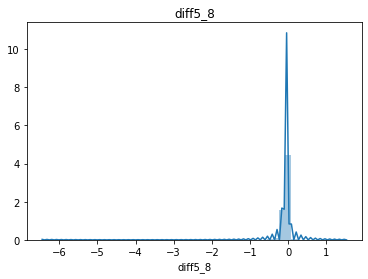

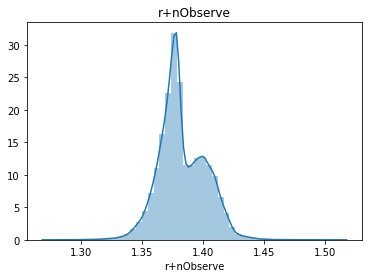

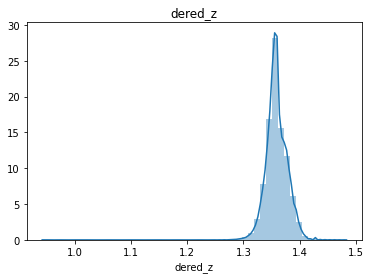

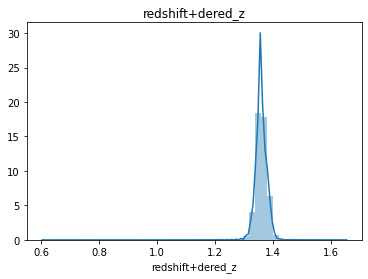

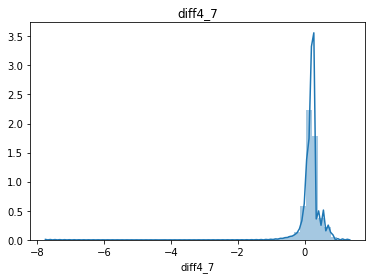

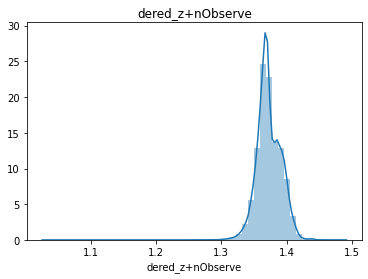

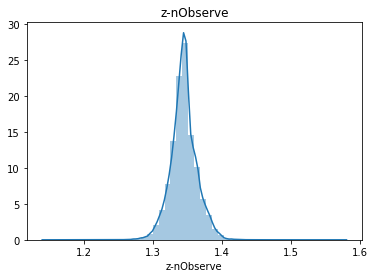

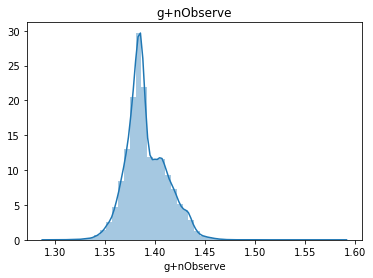

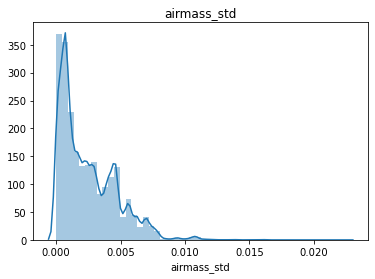

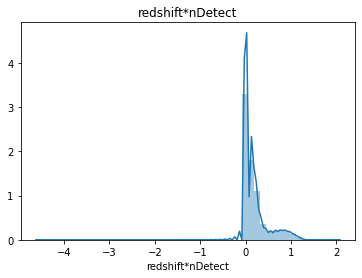

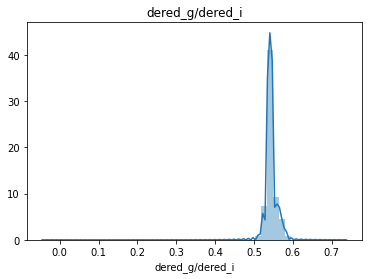

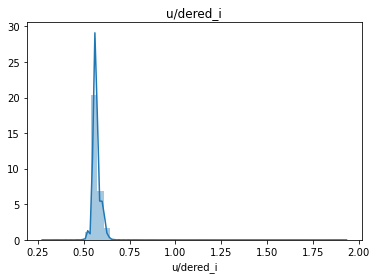

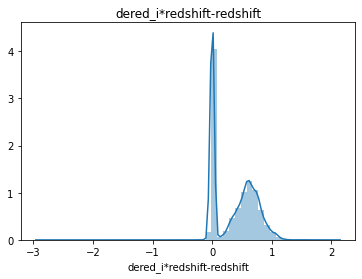

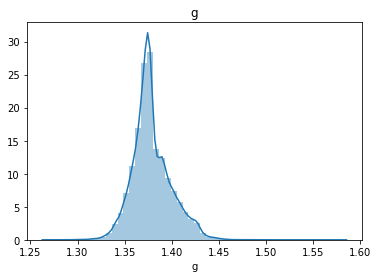

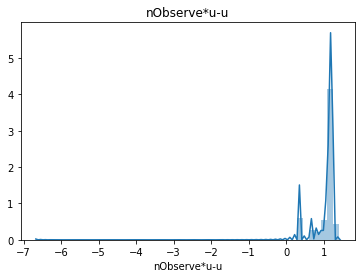

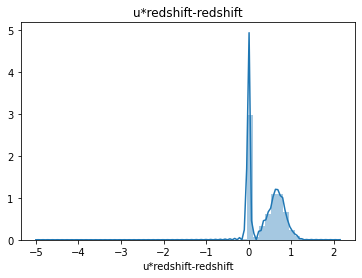

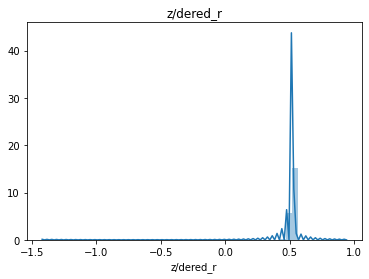

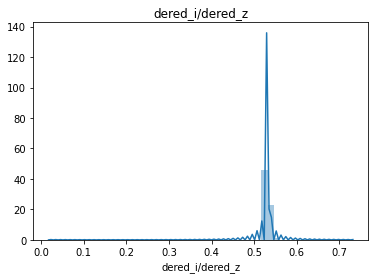

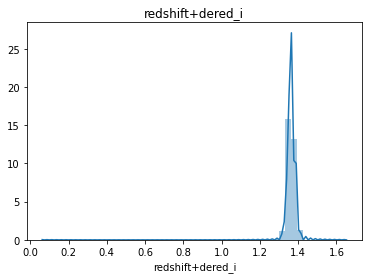

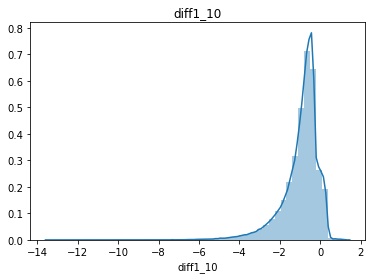

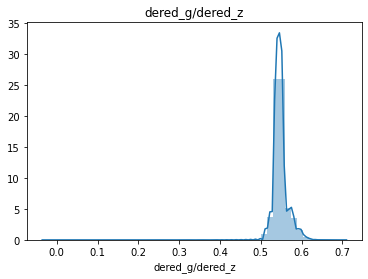

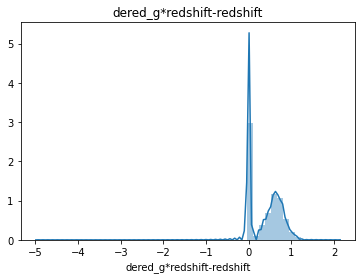

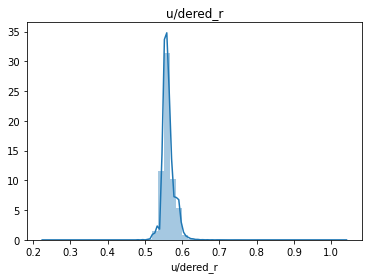

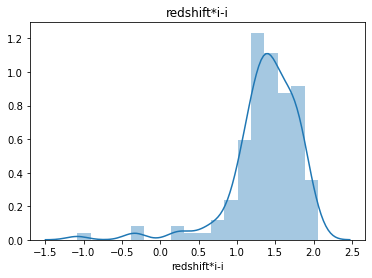

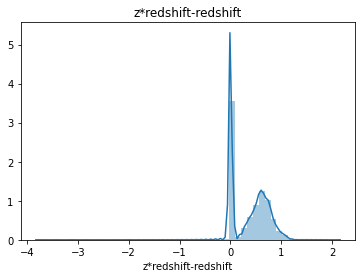

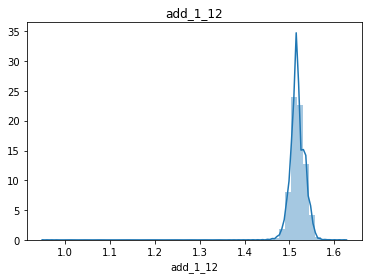

C:\Users\munan\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


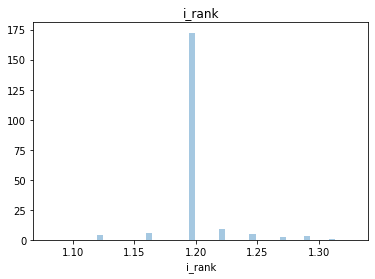

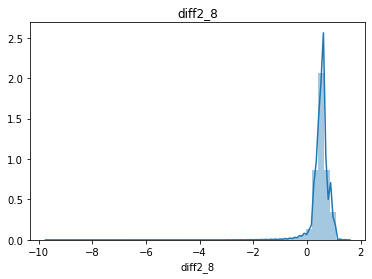

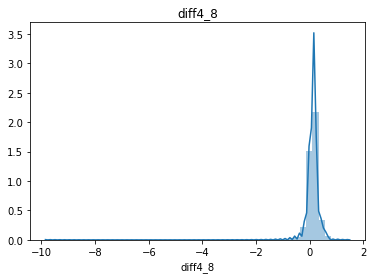

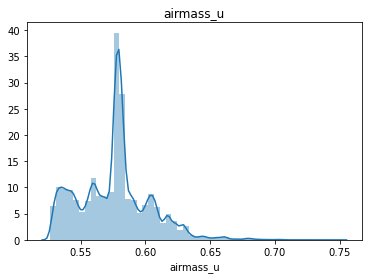

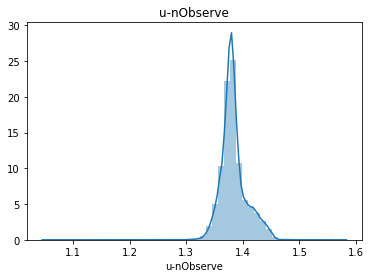

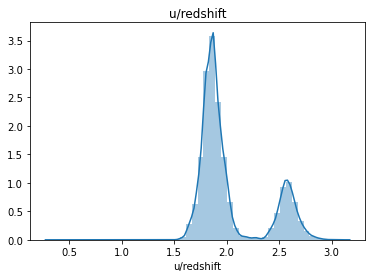

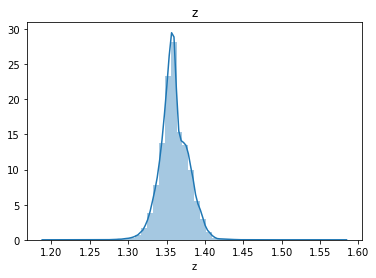

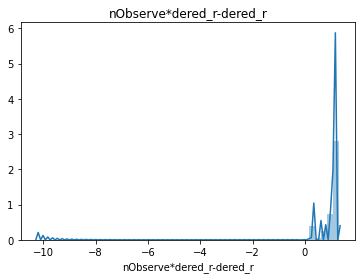

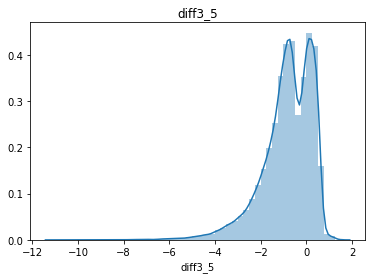

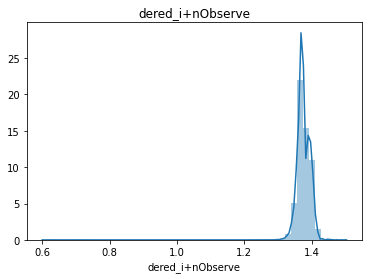

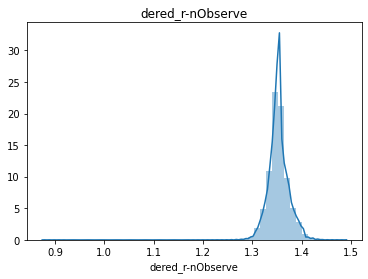

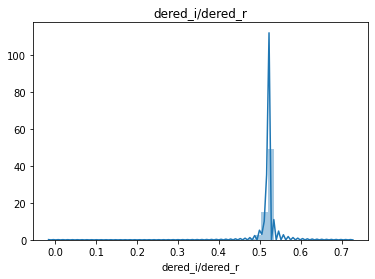

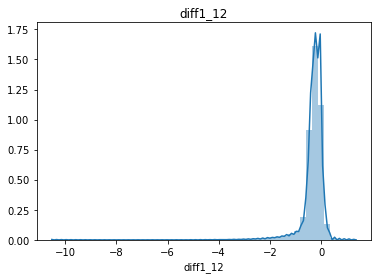

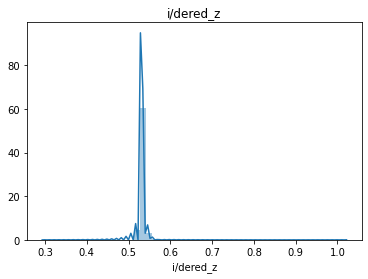

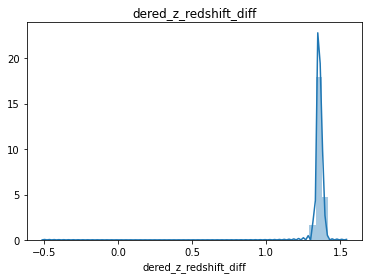

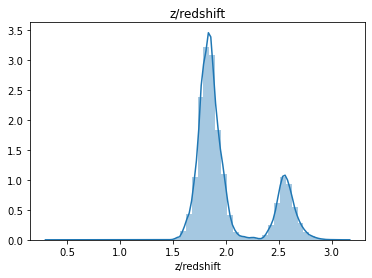

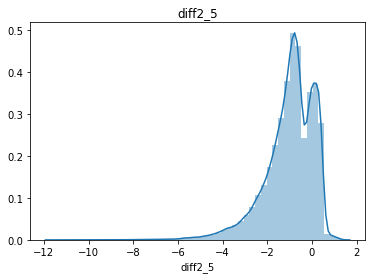

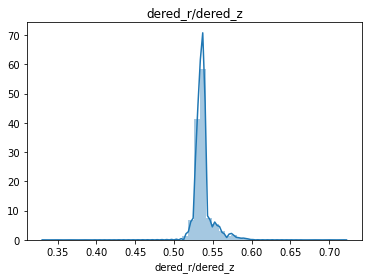

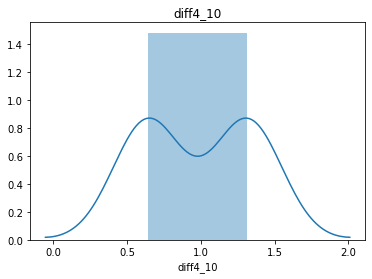

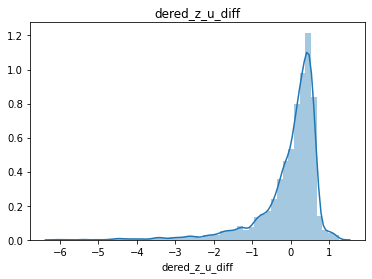

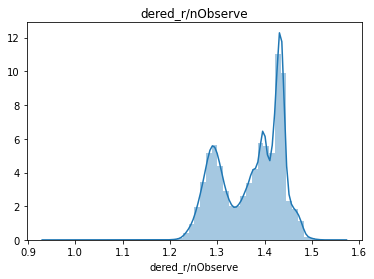

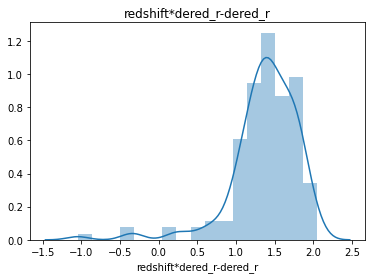

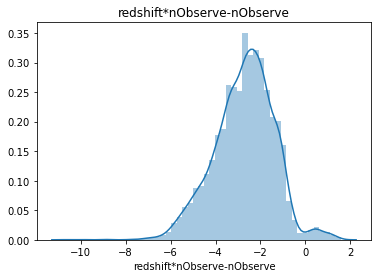

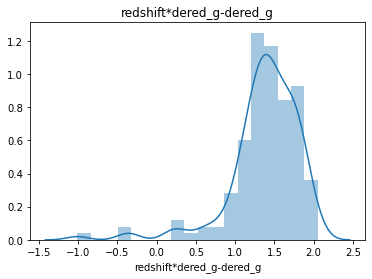

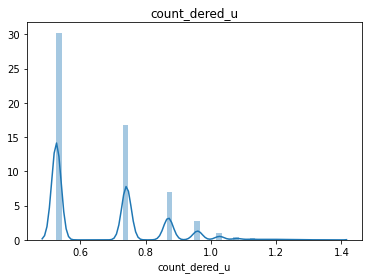

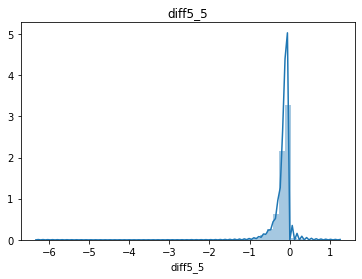

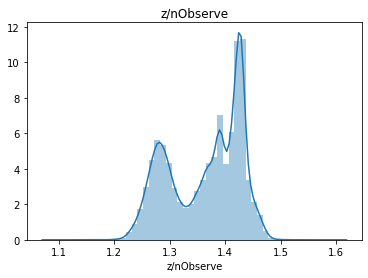

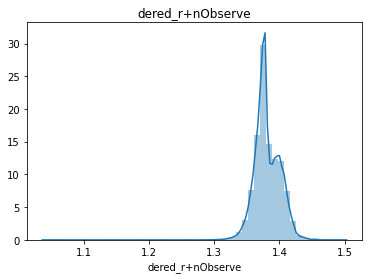

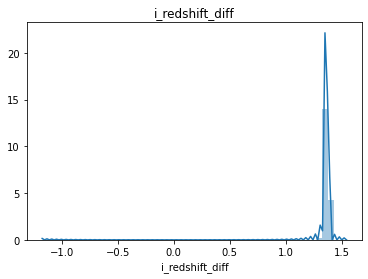

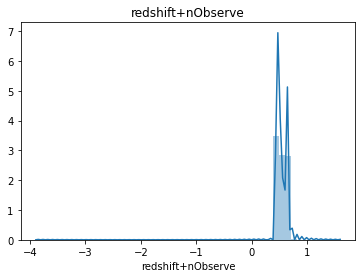

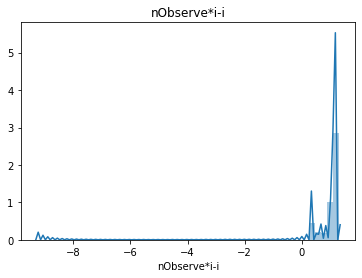

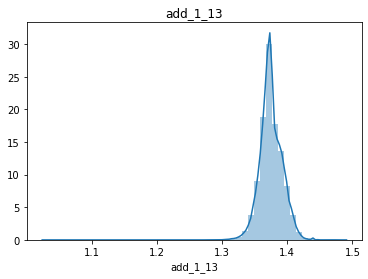

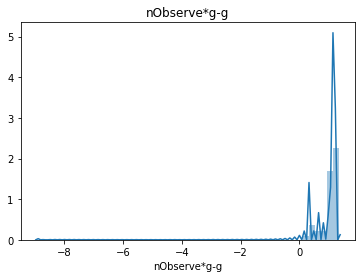

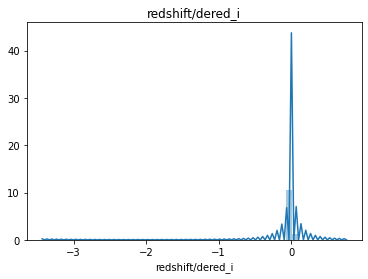

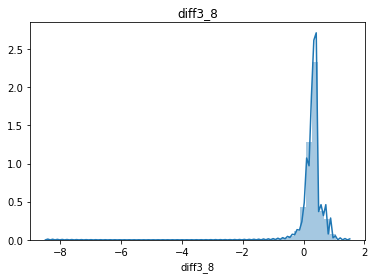

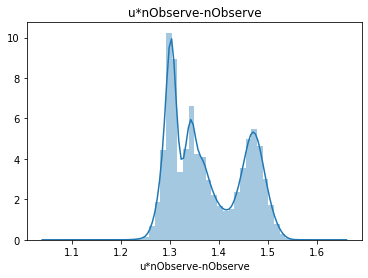

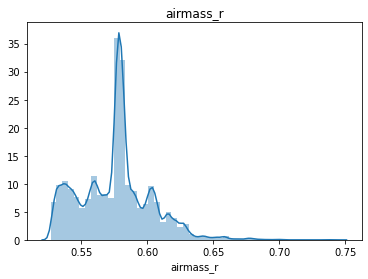

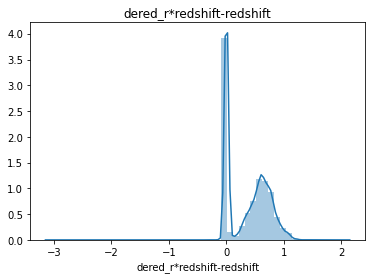

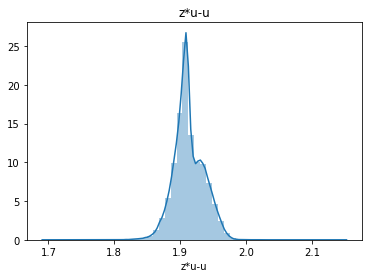

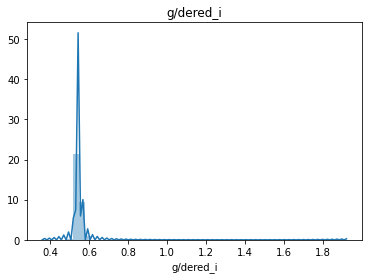

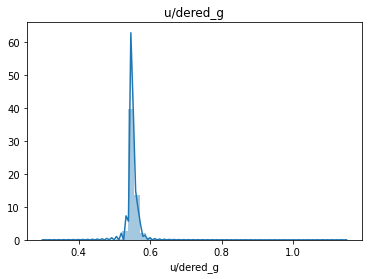

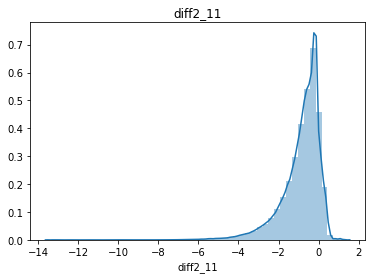

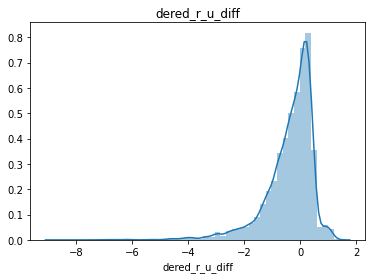

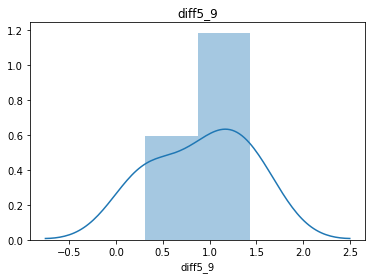

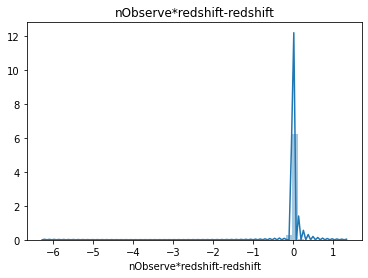

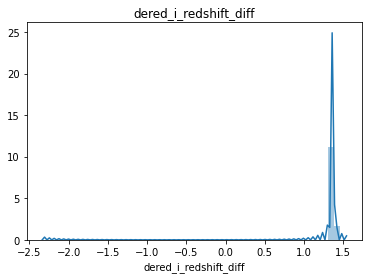

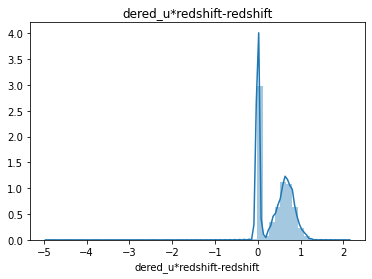

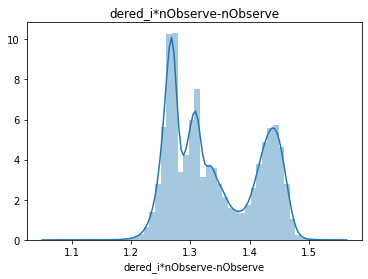

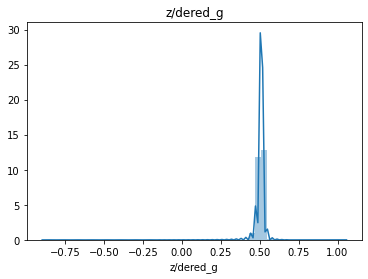

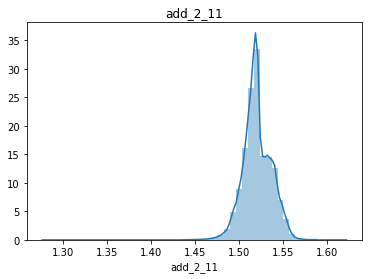

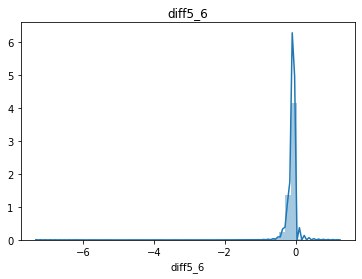

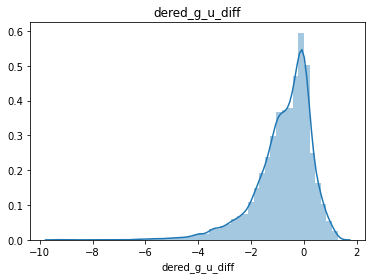

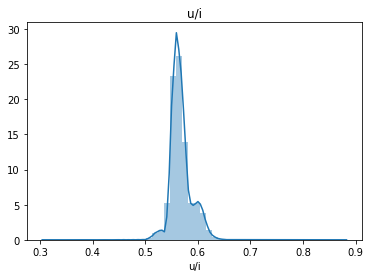

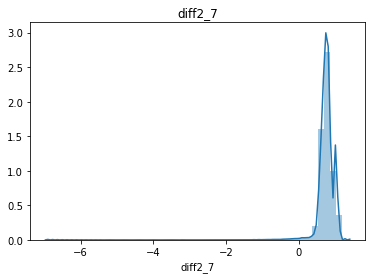

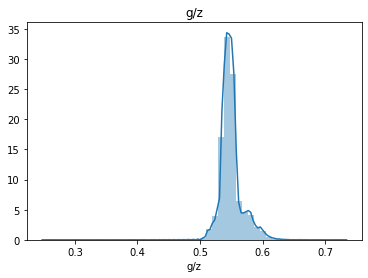

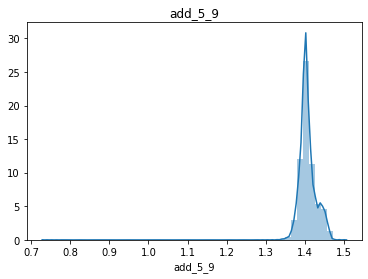

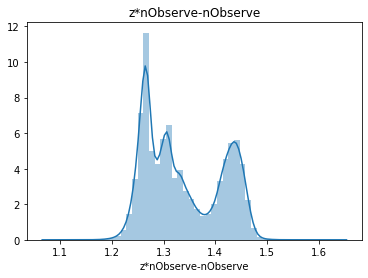

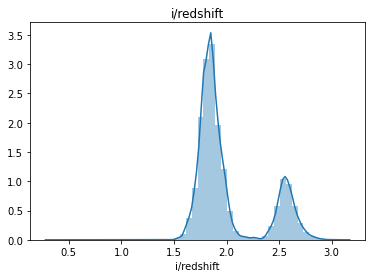

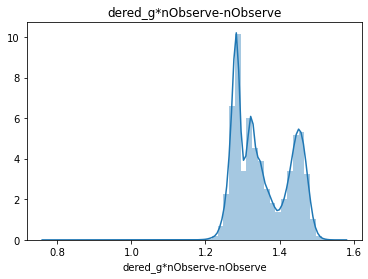

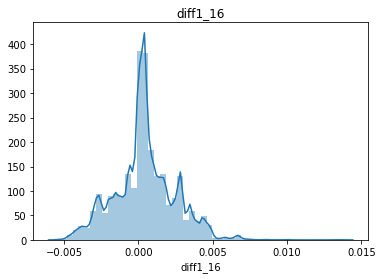

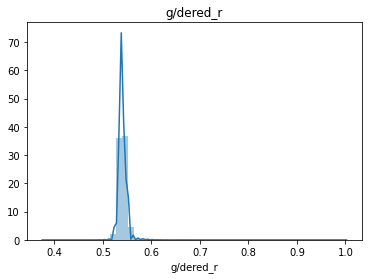

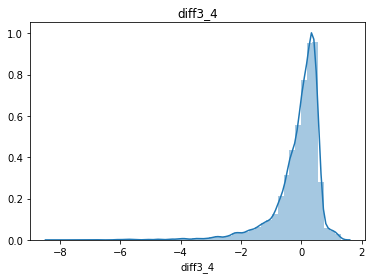

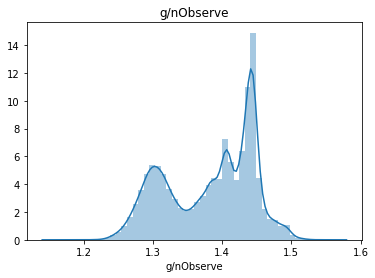

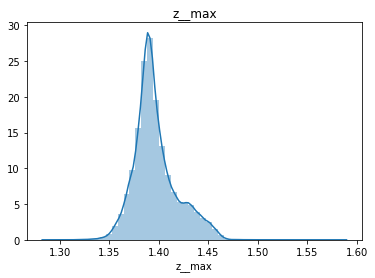

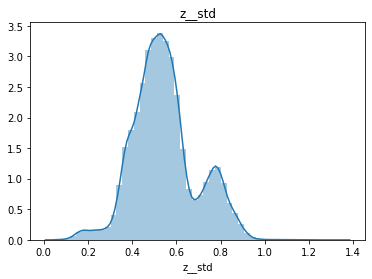

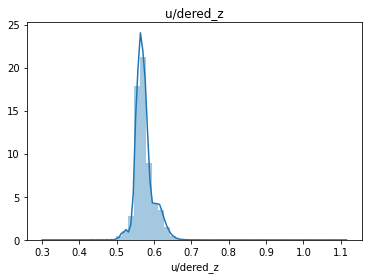

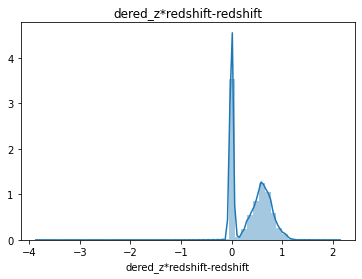

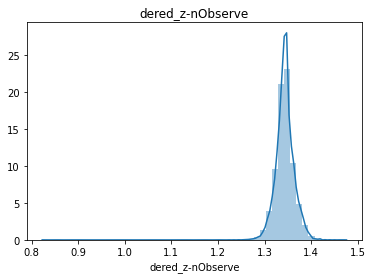

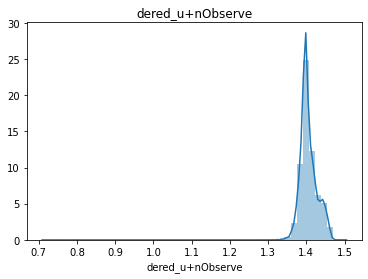

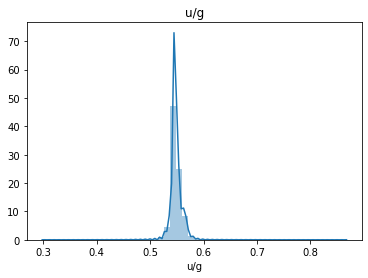

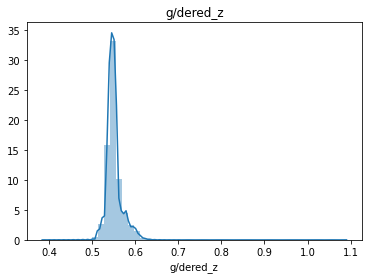

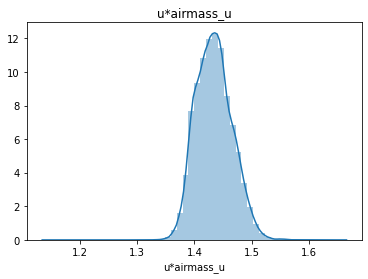

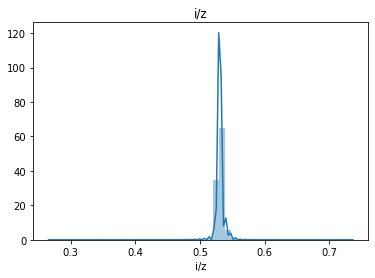

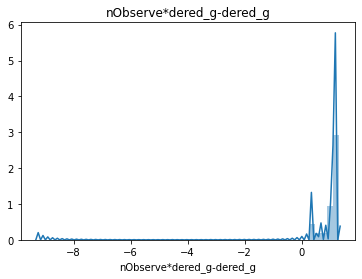

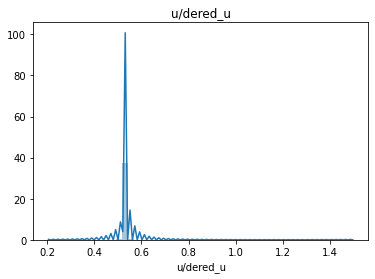

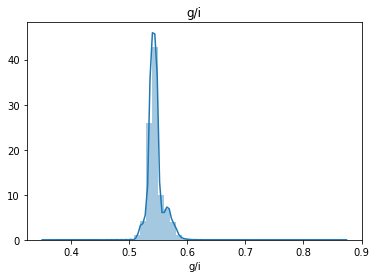

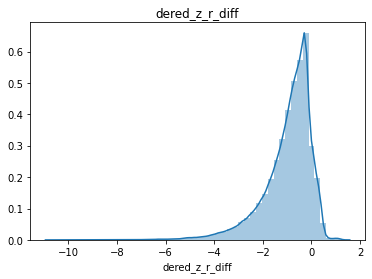

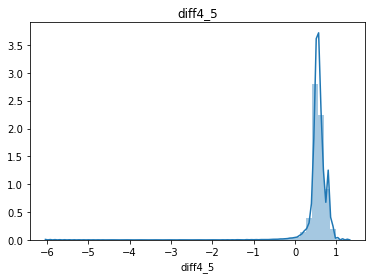

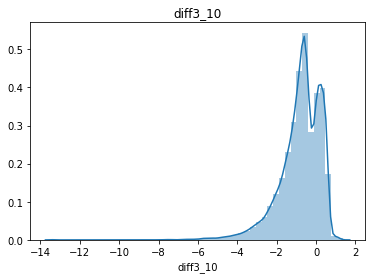

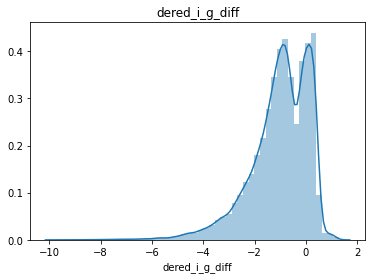

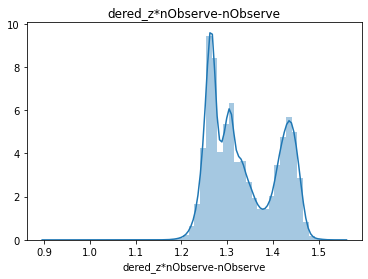

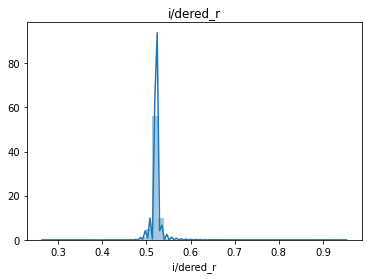

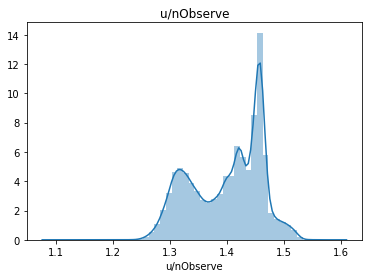

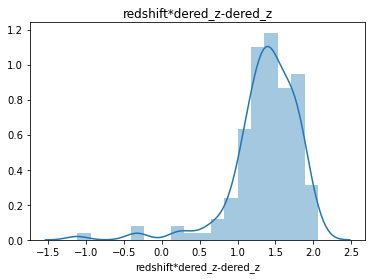

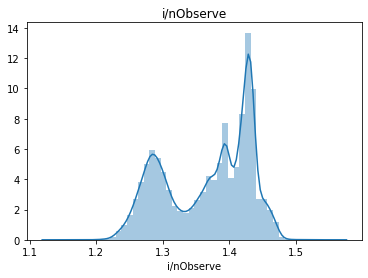

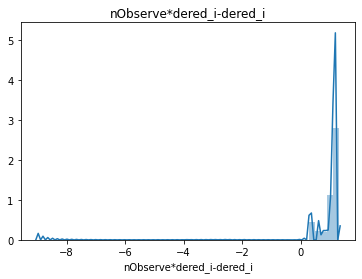

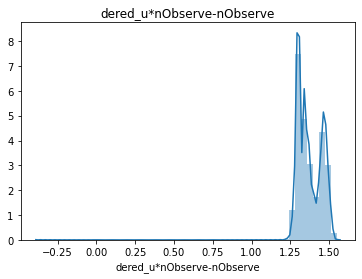

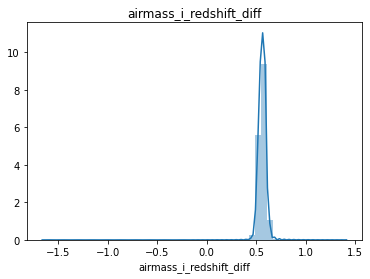

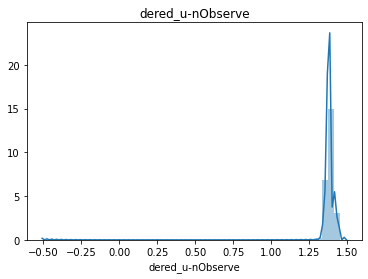

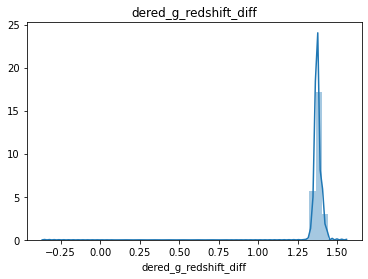

C:\Users\munan\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


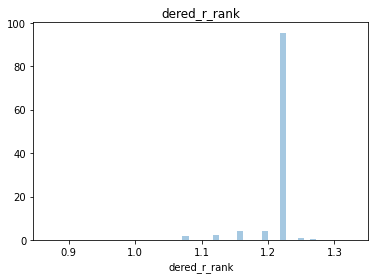

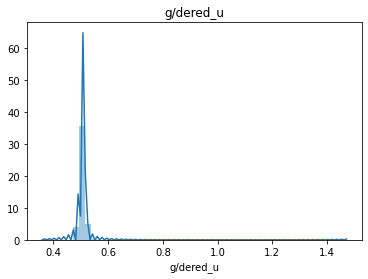

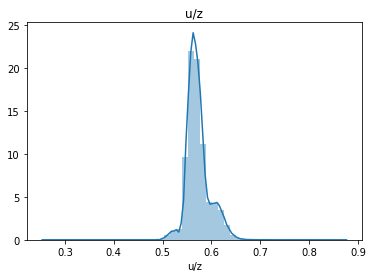

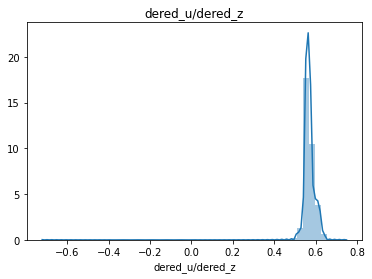

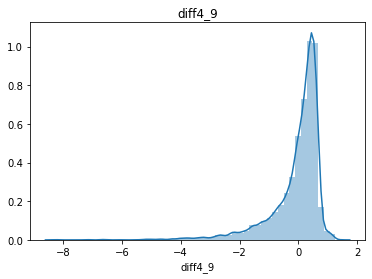

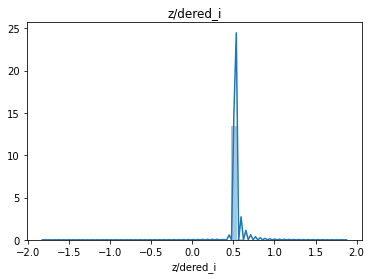

C:\Users\munan\Anaconda3\lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\munan\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\munan\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


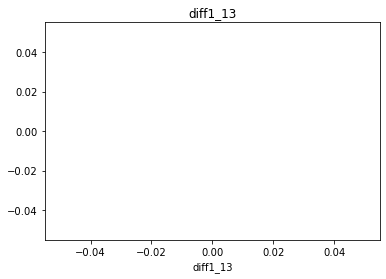

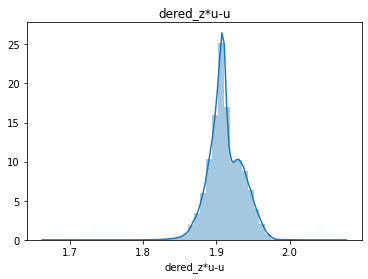

KeyboardInterrupt: 

In [392]:
for col in numerical_feature:
    sns.distplot(train_log_249.loc[train_log_249[col].notnull(), col])
    plt.title(col)
    plt.show()


In [395]:
for col in numerical_feature:
    test_log_249[col] = np.log1p(test_log_249.loc[test_log_249[col].notnull(), col])

## 400개

In [399]:
numerical_feature = new_train_set_under_454.columns

In [400]:
train_log_454 = new_train_set_under_454.copy()
test_log_454 = new_test_set_under_454.copy()

In [401]:
for col in numerical_feature:
    train_log_454[col] = np.log1p(new_train_set_under_454.loc[new_train_set_under_454[col].notnull(), col])

C:\Users\munan\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\munan\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [402]:
for col in numerical_feature:
    train_log_454[col] = np.log1p(train_log_454.loc[train_log_454[col].notnull(), col])

In [403]:
for col in numerical_feature:
    test_log_454[col] = np.log1p(new_test_set_under_454.loc[new_test_set_under_454[col].notnull(), col])

In [404]:
for col in numerical_feature:
    test_log_454[col] = np.log1p(test_log_454.loc[test_log_454[col].notnull(), col])

In [442]:
numerical_feature = train2_.columns

In [443]:
train_log_800 = train2_.copy()
test_log_800 = test2_.copy()

In [444]:
for col in numerical_feature:
    train_log_800[col] = np.log1p(train2_.loc[train2_[col].notnull(), col])

C:\Users\munan\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\munan\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [445]:
for col in numerical_feature:
    train_log_800[col] = np.log1p(train_log_800.loc[train_log_800[col].notnull(), col])

In [446]:
for col in numerical_feature:
    test_log_800[col] = np.log1p(test_log_800.loc[test_log_800[col].notnull(), col])

In [447]:
for col in numerical_feature:
    test_log_800[col] = np.log1p(test_log_800.loc[test_log_800[col].notnull(), col])

## train_log_249 Log함수 적용한 트레이닝 셋
## train_log_454 Log 함수 적용한 트레이닝 셋

In [405]:
train_columns = numerical_feature

In [409]:
lgb_param_dart = {'objective': 'multiclass', 
 'num_class': 13, 
 'boosting_type': 'dart', 
 'subsample_freq': 5, 
 'num_leaves': 92, 
 'min_data_in_leaf': 64, 
 'subsample_for_bin': 23000, 
 'max_depth': 10, 
 'feature_fraction': 0.302, 
 'bagging_fraction': 0.904, 
 'lambda_l1': 0.099, 
 'lambda_l2': 1.497, 
 'min_child_weight': 38.011, 
 'nthread': 32, 
 'metric': 'multi_logloss', 
 'learning_rate': 0.021, 
 'min_sum_hessian_in_leaf': 3, 
 'drop_rate': 0.846244, 
 'skip_drop': 0.792465, 
 'max_drop': 65,
 'seed': 42,
 'n_estimators': 2000}

In [460]:
train_columns = train_log_454.columns

In [466]:
for col in train_columns:
    if train_log_454[col].dtype=='float64': train_log_454[col] = train_log_454[col].astype('float32')
    if train_log_454[col].dtype=='int64': train_log_454[col] = train_log_454[col].astype('int32')
        
for col in train_columns:
    if test_log_454[col].dtype=='float64': test_log_454[col] = test_log_454[col].astype('float32')
    if test_log_454[col].dtype=='int64': test_log_454[col] = test_log_454[col].astype('int32')

MemoryError: Unable to allocate 738. MiB for an array with shape (453, 213410) and data type float64

In [461]:
print(lgb_param_dart)
x_train = train_log_454.copy()
y_train = Y
x_test = test_log_454.copy()

num_class = 3
oof_train = np.zeros((len(x_train),num_class))
oof_test = np.zeros((len(x_test),num_class))
log_loss_score_list= []   
NFOLD = 5
SEED = 42

# stratifiedkfold 5 fold 사용
folds = StratifiedKFold(n_splits=NFOLD, shuffle=True, random_state=42)
for fold_, (trn_index, val_index) in enumerate(folds.split(x_train, y_train)):
    print(f"{fold_+1} FOLD Start!!")
    trn_x, trn_y = x_train.iloc[trn_index][train_columns], y_train.iloc[trn_index]
    val_x, val_y = x_train.iloc[val_index][train_columns], y_train.iloc[val_index]
    dtrain = lgbm.Dataset(trn_x, label=trn_y, silent=True)
    dcross = lgbm.Dataset(val_x, label=val_y, silent=True)
    
    # dart는 얼리스탑핑이 안되서 한번 num_boost_round를 넉넉히 돌린다음에 5fold에서 가장 좋았던 round로 고정하고 돌린다.
    clf = lgbm.train(lgb_param_dart, train_set=dtrain, num_boost_round=1000, valid_sets=[dtrain, dcross], 
                       verbose_eval=100)
    
    val_pred = clf.predict(val_x)
    oof_train[val_index, :] = val_pred
    
    log_loss_score = log_loss(val_y, val_pred)
    log_loss_score_list.append(log_loss_score)
    print(f"{fold_+1} FOLD LogLoss: ", log_loss_score)
    
    # 5fold 평균으로 제출
    
    oof_test += clf.predict(x_test[train_columns])/NFOLD

{'objective': 'multiclass', 'num_class': 13, 'boosting_type': 'dart', 'subsample_freq': 5, 'num_leaves': 92, 'min_data_in_leaf': 64, 'subsample_for_bin': 23000, 'max_depth': 10, 'feature_fraction': 0.302, 'bagging_fraction': 0.904, 'lambda_l1': 0.099, 'lambda_l2': 1.497, 'min_child_weight': 38.011, 'nthread': 32, 'metric': 'multi_logloss', 'learning_rate': 0.021, 'min_sum_hessian_in_leaf': 3, 'drop_rate': 0.846244, 'skip_drop': 0.792465, 'max_drop': 65, 'seed': 42, 'n_estimators': 2000}


MemoryError: Unable to allocate 739. MiB for an array with shape (454, 213410) and data type float64

In [458]:
oof_test

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [448]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(train_log_800, Y, test_size=test_size, random_state=seed)

In [449]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [450]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [451]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.32%


In [452]:
dtrain = xgb.DMatrix(X_train,label=y_train)

In [453]:
dval = xgb.DMatrix(X_test,label=y_test)

In [431]:
def XGB_cv(max_depth,learning_rate, n_estimators, gamma
           ,min_child_weight, max_delta_step, subsample
           ,colsample_bytree, silent=True, nthread=-1):
    model = xgb.XGBClassifier(max_depth=int(max_depth),
                              learning_rate=learning_rate,
                              n_estimators=int(n_estimators),
                              silent=silent,
                              nthread=nthread,
                              gamma=gamma,
                              min_child_weight=min_child_weight,
                              max_delta_step=max_delta_step,
                              subsample=subsample,
                              colsample_bytree=colsample_bytree)
    RMSE = cross_val_score(model,X_train, y_train, scoring='accuracy', cv=5).mean()
    return RMSE

In [430]:
pbounds = {'max_depth': (5, 10),
          'learning_rate': (0, 0.5),
          'n_estimators': (50, 1000),
          'gamma': (0.01, 1),
          'min_child_weight': (0,10),
          'max_delta_step': (0, 0.1),
          'subsample': (0, 0.8),
          'colsample_bytree' :(0, 0.99),
          }

In [432]:
xgboostBO = BayesianOptimization(f = XGB_cv, pbounds = pbounds, verbose = 2, random_state = 1 )

In [433]:
# 반복적으로 베이지안 최적화 수행
# 시간을 줄이기 위해 N-n 값 10으로 지정
# acq='ei'사용
# xi=0.01 로 exploration의 강도를 조금 높임
xgboostBO.maximize(init_points=2, n_iter = 10, acq='ei', xi=0.01)

|   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------
[15:15:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:17:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abo

KeyboardInterrupt: 

In [435]:
xgboostBO.max

{'target': 0.9211660095617417,
 'params': {'colsample_bytree': 0.39279979948836324,
  'gamma': 0.5434285666633234,
  'learning_rate': 0.2095972572016474,
  'max_delta_step': 0.06852195003967596,
  'max_depth': 6.022261248657587,
  'min_child_weight': 8.781174363909454,
  'n_estimators': 76.01821353802985,
  'subsample': 0.5363740081427218}}

In [454]:
params: {'num_class':3,
    'colsample_bytree': 0.39279979948836324,
  'gamma': 0.5434285666633234,
  'learning_rate': 0.2095972572016474,
  'max_delta_step': 0.06852195003967596,
  'max_depth': 6.022261248657587,
  'min_child_weight': 8.781174363909454,
  'n_estimators': 76.01821353802985,
  'subsample': 0.5363740081427218}

In [455]:
model = xgb.train(params,dtrain)

In [456]:
y_pred = model.predict(dval)
predictions = [round(value) for value in y_pred]

In [457]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.02%
